<a href="https://colab.research.google.com/github/bgh2104/SCproject/blob/main/Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install pdpbox
!pip install xgboost==1.7.2
!pip install shap
!pip3 install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikit-learn==1.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

upload = files.upload()

Saving train_sample.csv to train_sample (1).csv


In [5]:
df = pd.read_csv('train_sample.csv')

In [6]:
# 본래 캐글 대회에서는 train set과 test set이 나뉘어 있으나, 여기에서는 test set에 타겟값이 없고,train set의 크기가 충분히 큰 점을 고려하여 train set 데이터를 train/val/test로 나누어 진행할 예정.
# train set에 attributed_time 결측치 아주 많이 존재

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [7]:
# 데이터 설명

# ip: ip address of click.
# app: app id for marketing.
# device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
# os: os version id of user mobile phone
# channel: channel id of mobile ad publisher
# click_time: timestamp of click (UTC)
# (삭제)attributed_time: if user download the app for after clicking an ad, this is the time of the app download
# is_attributed: the target that is to be predicted, indicating the app was downloaded

# The test data is similar, with the following differences:

# click_id: reference for making predictions
# is_attributed: not included

In [8]:
#attributed_time 컬럼 삭제
df.drop('attributed_time', axis=1, inplace=True)
df.reset_index(drop=True)
df

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0
...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,0


In [9]:
#중복값 1개 제거
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ip             99999 non-null  int64 
 1   app            99999 non-null  int64 
 2   device         99999 non-null  int64 
 3   os             99999 non-null  int64 
 4   channel        99999 non-null  int64 
 5   click_time     99999 non-null  object
 6   is_attributed  99999 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 6.1+ MB


In [10]:
####????? 어차피 트리 모델이라 상관없지 않나? 보류

# 유니크한 값 : 전반적으로 카디널리티가 높은데, 특히 ip의 카디널리티가 너무 높음...!!! ip삭제 필요
# df.drop('ip', axis=1, inplace=True)
# df.reset_index(drop=True)
# df

In [11]:
# 클릭시간은 연도/월/주말(평일)/시간대별로 코딩 필요
df.info()
# df['click_time'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ip             99999 non-null  int64 
 1   app            99999 non-null  int64 
 2   device         99999 non-null  int64 
 3   os             99999 non-null  int64 
 4   channel        99999 non-null  int64 
 5   click_time     99999 non-null  object
 6   is_attributed  99999 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 6.1+ MB


In [12]:
# click_time 특수문자 제거

import re

df['click_time_enc'] = df['click_time'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
df['click_time_enc'].info()

<class 'pandas.core.series.Series'>
Int64Index: 99999 entries, 0 to 99999
Series name: click_time_enc
Non-Null Count  Dtype 
--------------  ----- 
99999 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [13]:
# 2017년 11월 제거 (2017년 11월 6일~9일까지의 데이터이므로)

df['click_time_enc'] = df['click_time_enc'].str[6:-2]

In [14]:
df['click_time_enc'] = df['click_time_enc'].astype(int)
df['click_time_enc'].describe()

count    99999.000000
mean     79576.600166
std       8743.121169
min      61600.000000
25%      71134.000000
50%      80707.000000
75%      90206.000000
max      91559.000000
Name: click_time_enc, dtype: float64

In [15]:
df

,ip,app,device,os,channel,click_time,is_attributed,click_time_enc
0,87540,12,1,13,497,2017-11-07 09:30:38,0,70930
1,105560,25,1,17,259,2017-11-07 13:40:27,0,71340
2,101424,12,1,19,212,2017-11-07 18:05:24,0,71805
3,94584,13,1,13,477,2017-11-07 04:58:08,0,70458
4,68413,12,1,1,178,2017-11-09 09:00:09,0,90900
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,91325
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,71125
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,81138
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,81755


In [16]:
data = df
data.drop('click_time', axis=1, inplace=True)
data

,ip,app,device,os,channel,is_attributed,click_time_enc
0,87540,12,1,13,497,0,70930
1,105560,25,1,17,259,0,71340
2,101424,12,1,19,212,0,71805
3,94584,13,1,13,477,0,70458
4,68413,12,1,1,178,0,90900
...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,0,91325
99996,85150,9,1,13,244,0,71125
99997,18839,3,1,13,19,0,81138
99998,114276,15,1,12,245,0,81755


In [17]:
# 클릭날, 클릭시간 열 추가

data['click_time_enc'] = data['click_time_enc'].astype(str)

data['click_day'] = data['click_time_enc'].str[0]
data['click_hour'] = data['click_time_enc'].str[1:3]

data['click_time_enc'] = data['click_time_enc'].astype(int)
data['click_day'] = data['click_day'].astype(int)
data['click_hour'] = data['click_hour'].astype(int)
data

,ip,app,device,os,channel,is_attributed,click_time_enc,click_day,click_hour
0,87540,12,1,13,497,0,70930,7,9
1,105560,25,1,17,259,0,71340,7,13
2,101424,12,1,19,212,0,71805,7,18
3,94584,13,1,13,477,0,70458,7,4
4,68413,12,1,1,178,0,90900,9,9
...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,0,91325,9,13
99996,85150,9,1,13,244,0,71125,7,11
99997,18839,3,1,13,19,0,81138,8,11
99998,114276,15,1,12,245,0,81755,8,17


In [18]:
# data['click_nmae'] = data['click_hour']
# #늦을수록 숫자가 높아짐!!
# data['click_nmae'] = data['click_nmae'].replace([0,1,2,3,4,5,22,23,24], '4')
# data['click_nmae'] = data['click_nmae'].replace([6,7,8,9,10,11], '1')
# data['click_nmae'] = data['click_nmae'].replace([12,13,14,15,16,17], '2')
# data['click_nmae'] = data['click_nmae'].replace([18,19,20,21], '3')
# data['click_nmae'] = data['click_nmae'].astype(int)

data = data.drop('click_time_enc', axis=1)
data = data.reset_index(drop=True)
data

,ip,app,device,os,channel,is_attributed,click_day,click_hour
0,87540,12,1,13,497,0,7,9
1,105560,25,1,17,259,0,7,13
2,101424,12,1,19,212,0,7,18
3,94584,13,1,13,477,0,7,4
4,68413,12,1,1,178,0,9,9
...,...,...,...,...,...,...,...,...
99994,124883,11,1,19,122,0,9,13
99995,85150,9,1,13,244,0,7,11
99996,18839,3,1,13,19,0,8,11
99997,114276,15,1,12,245,0,8,17


count    99999.000000
mean        12.047880
std         14.941575
min          1.000000
25%          3.000000
50%         12.000000
75%         15.000000
max        551.000000
Name: app, dtype: float64

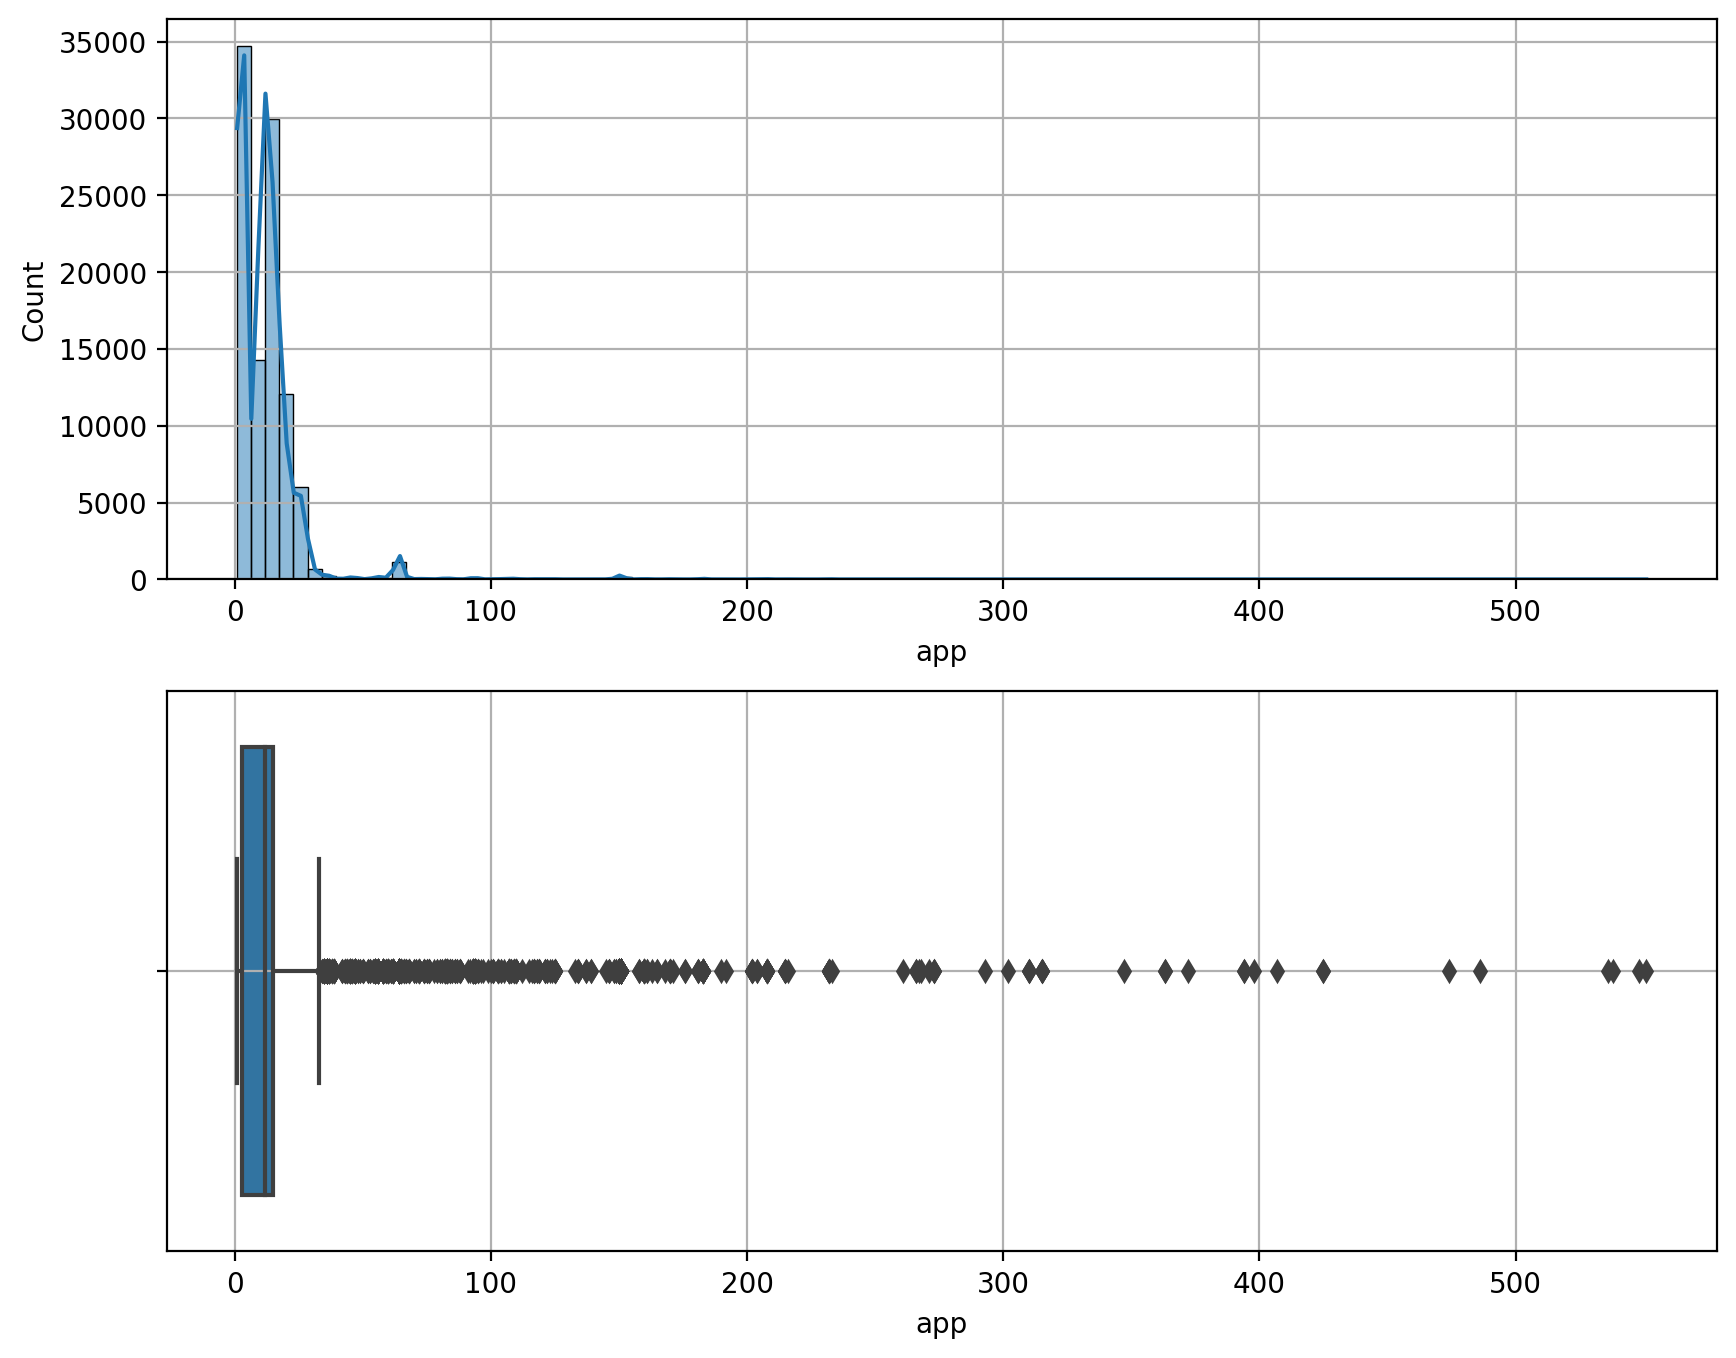

,count,ratio
3,18279,0.182792
12,13197,0.131971
2,11737,0.117371
9,8992,0.089921
15,8595,0.085951
...,...,...
145,1,0.000010
97,1,0.000010
96,1,0.000010
267,1,0.000010


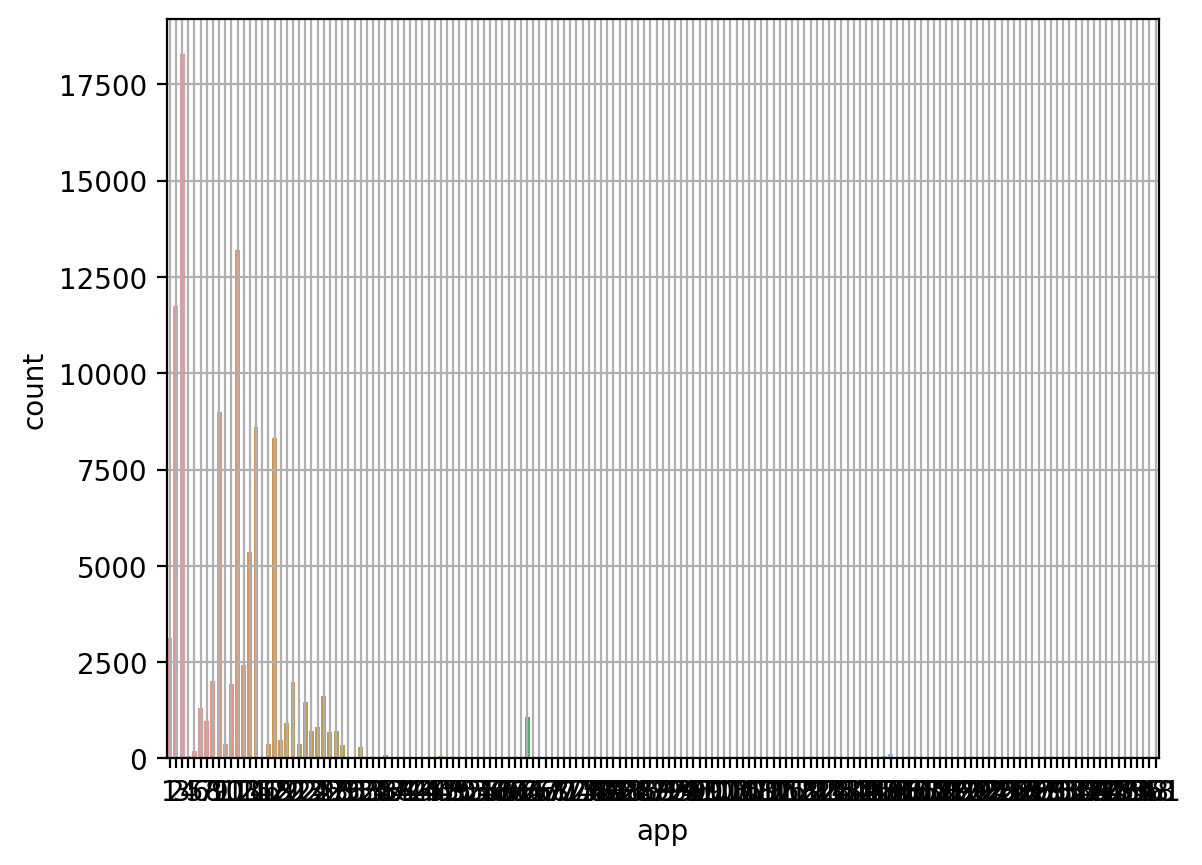

count    99999.000000
mean        21.771458
std        259.669057
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       3867.000000
Name: device, dtype: float64

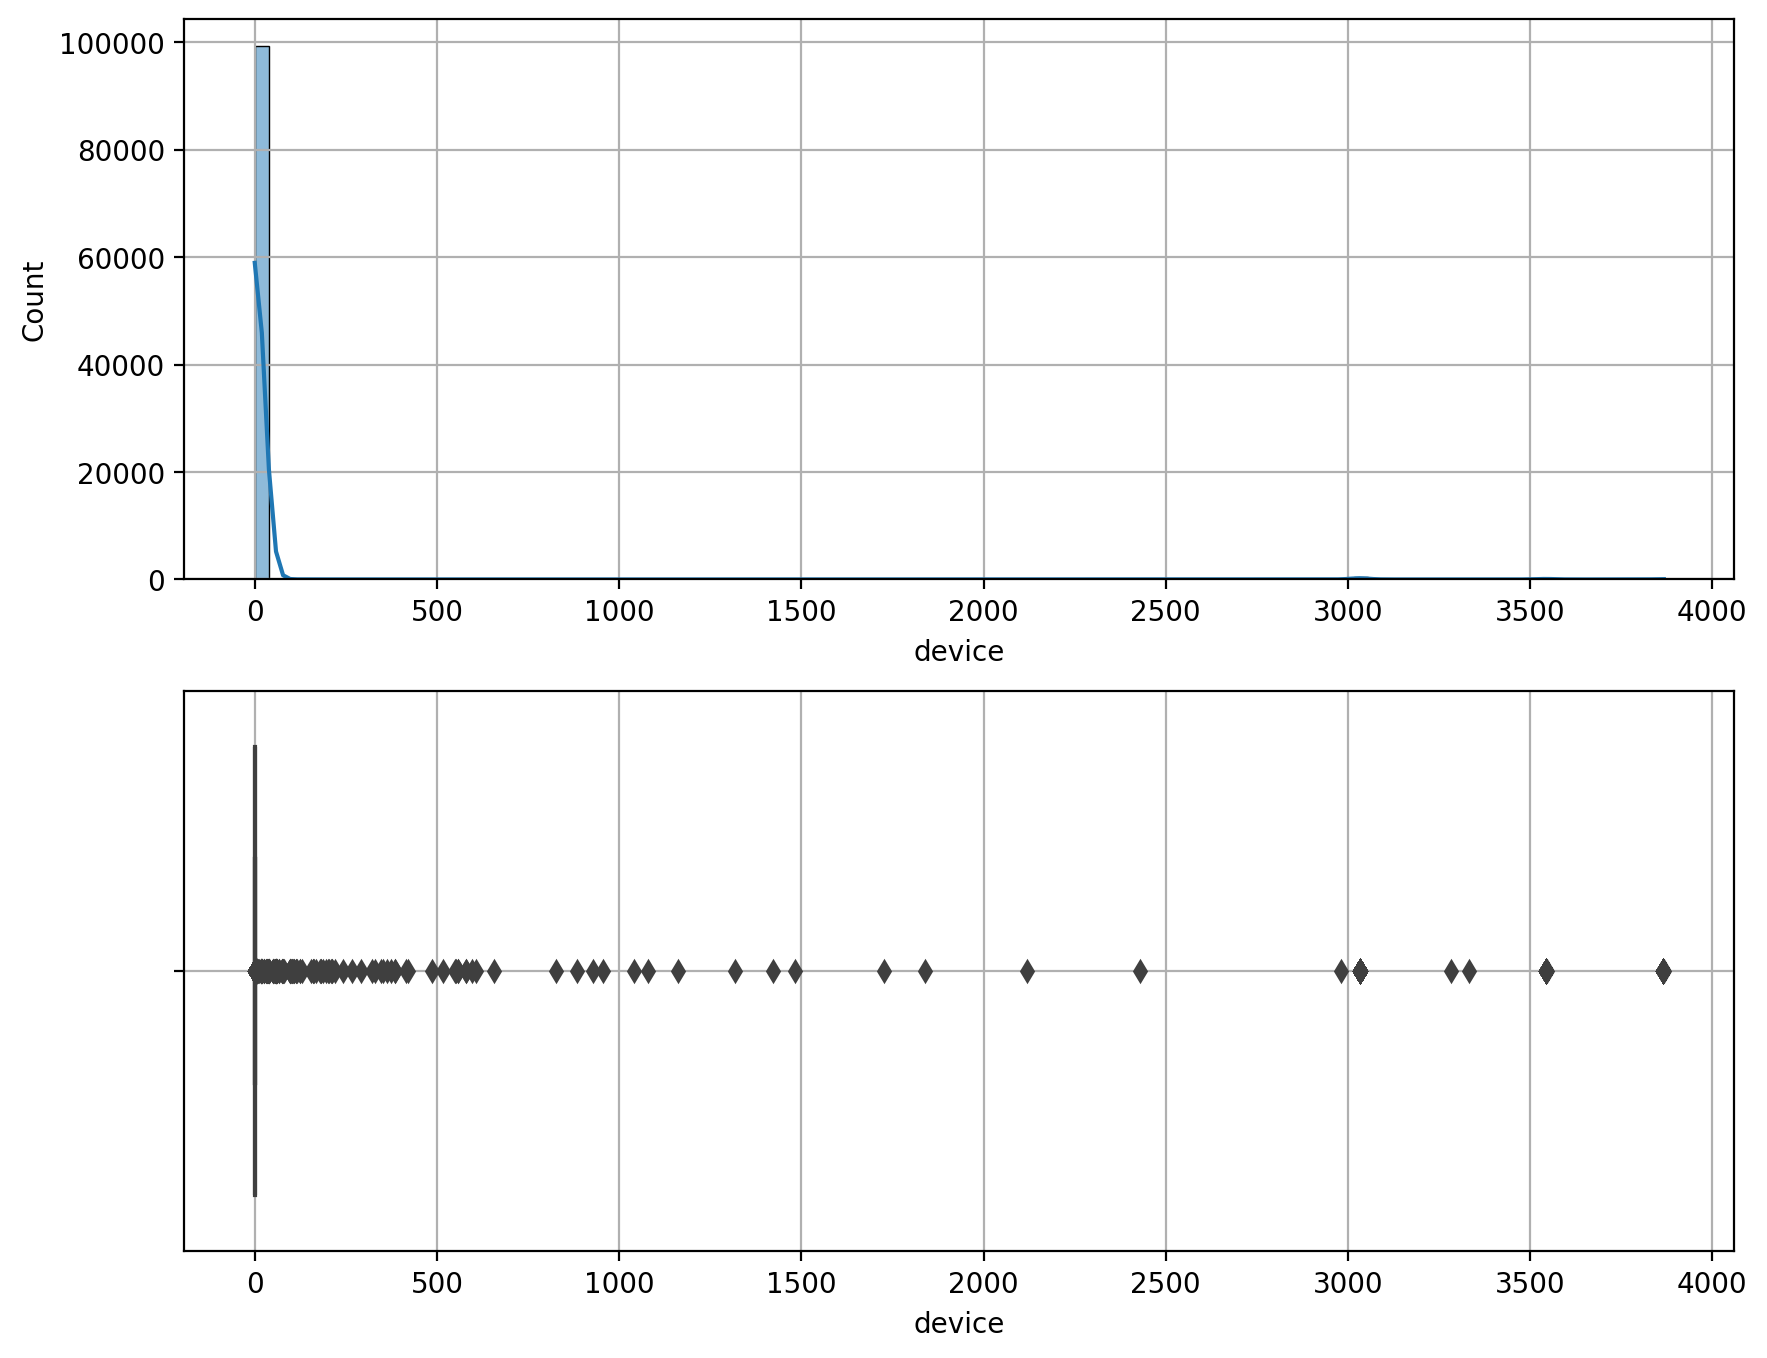

,count,ratio
1,94337,0.943379
2,4345,0.043450
0,541,0.005410
3032,371,0.003710
3543,151,0.001510
...,...,...
374,1,0.000010
76,1,0.000010
3282,1,0.000010
129,1,0.000010


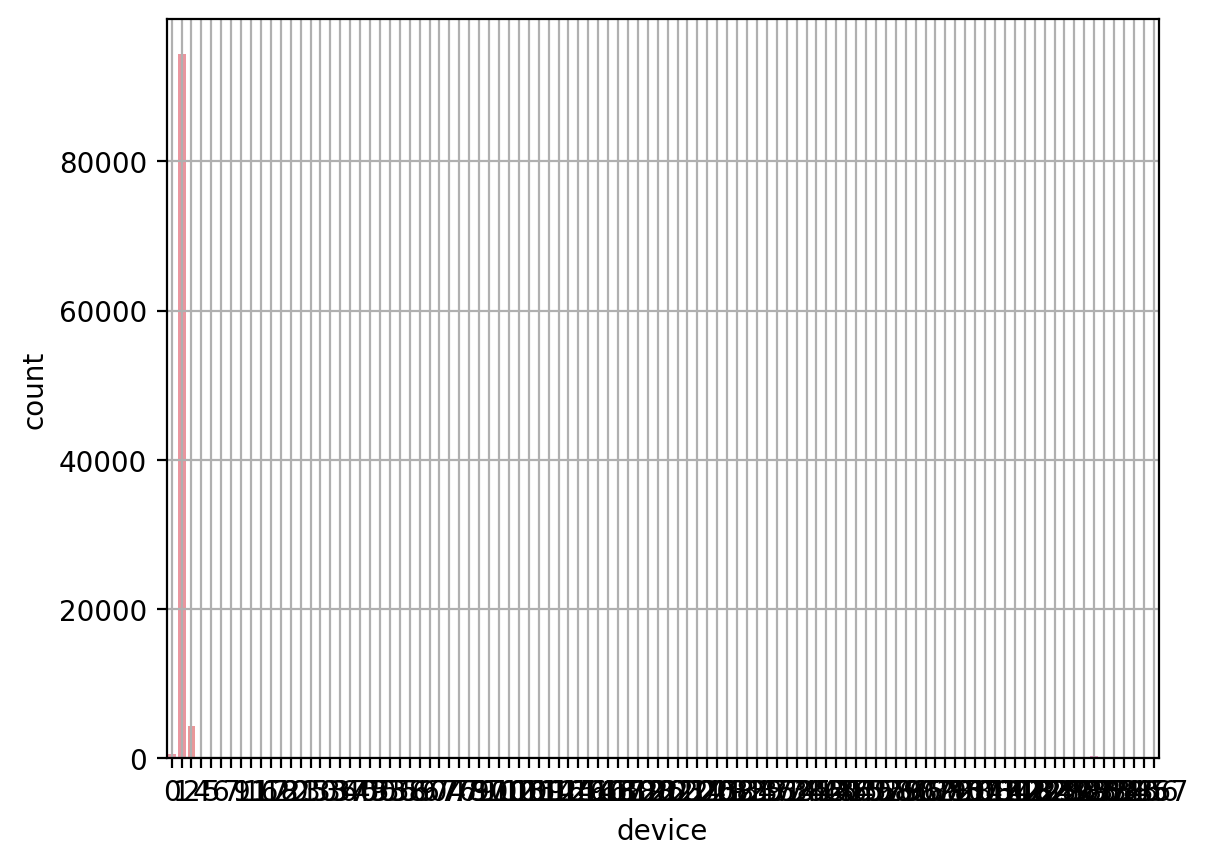

count    99999.000000
mean        22.818378
std         55.943407
min          0.000000
25%         13.000000
50%         18.000000
75%         19.000000
max        866.000000
Name: os, dtype: float64

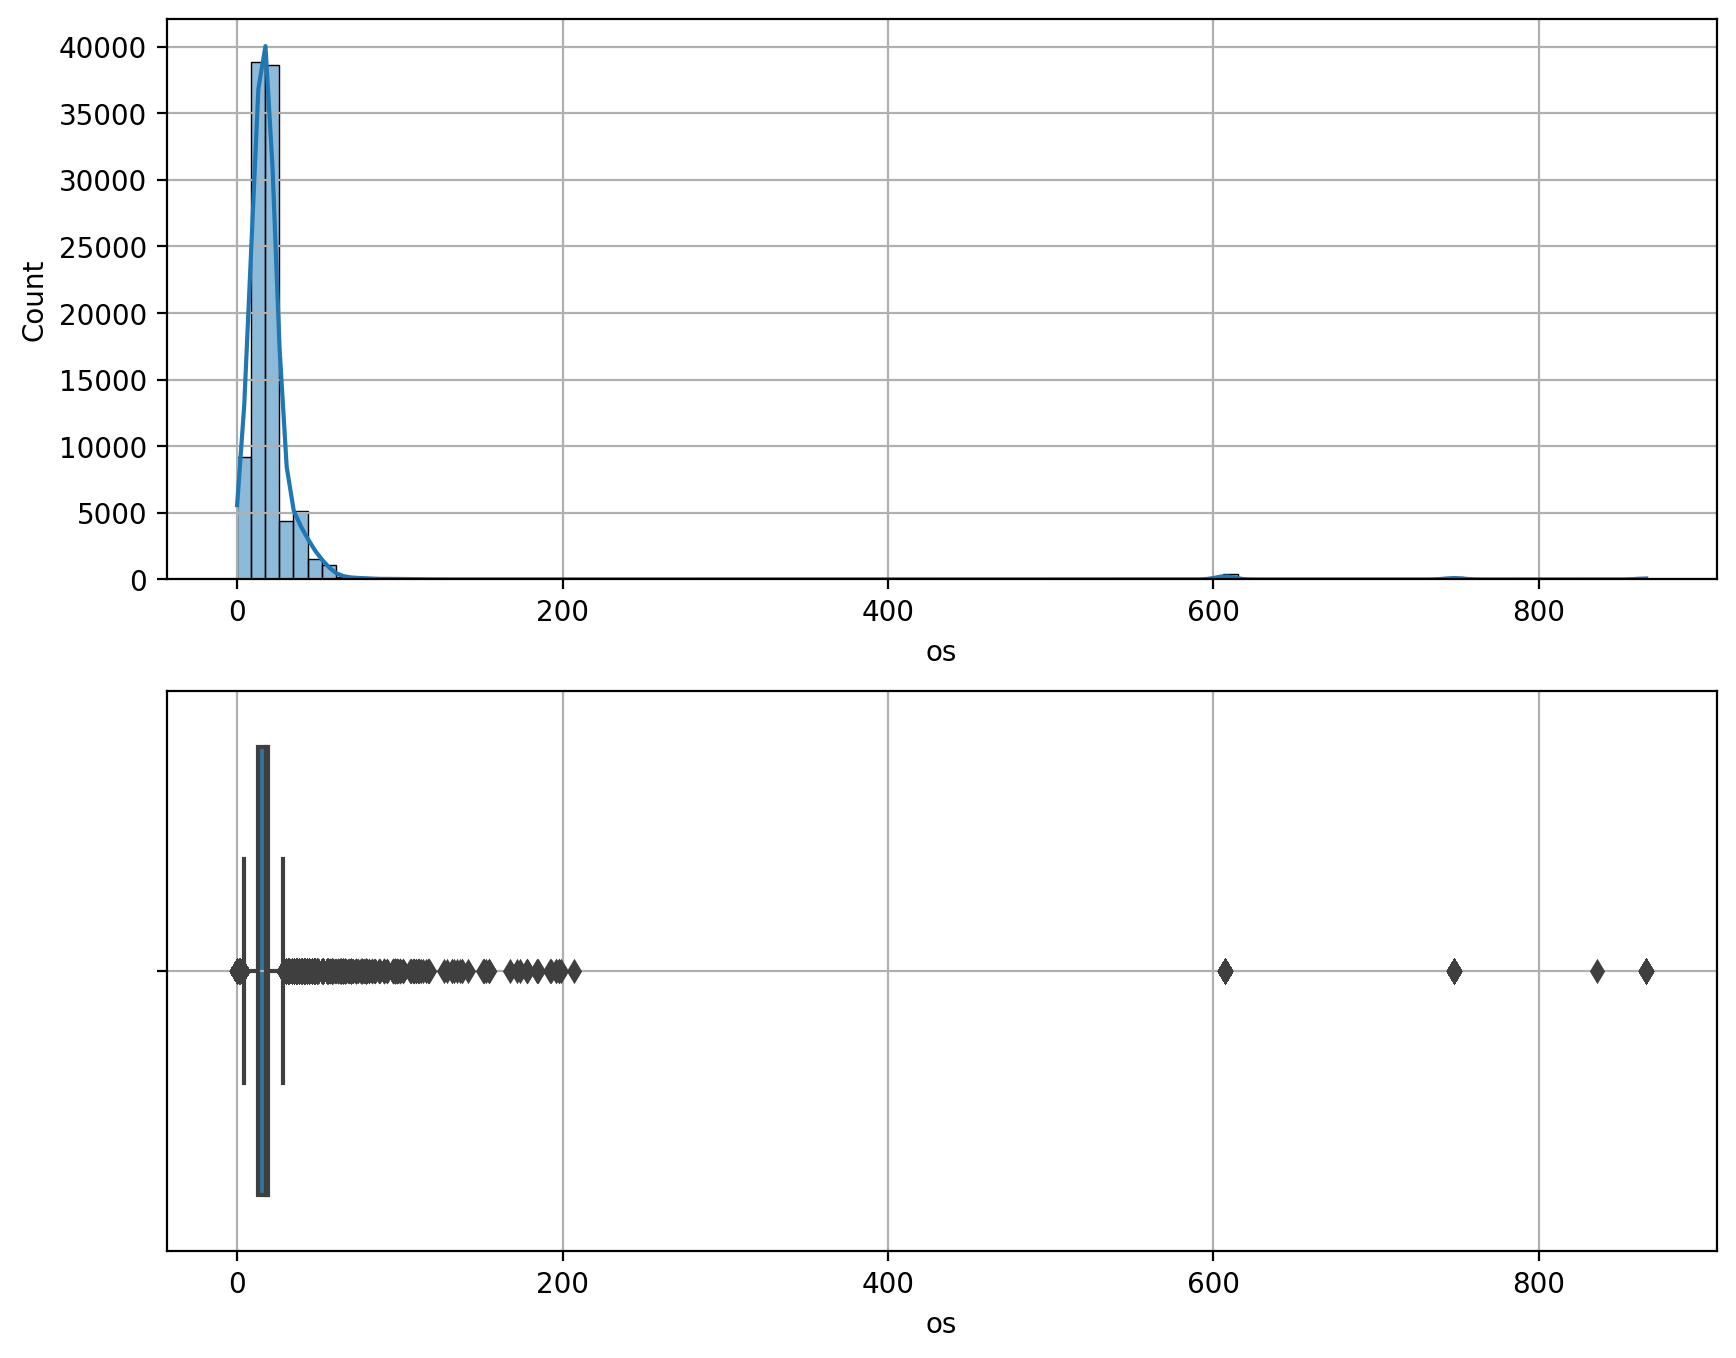

,count,ratio
19,23870,0.238702
13,21222,0.212222
17,5232,0.052321
18,4830,0.048300
22,4039,0.040390
...,...,...
153,1,0.000010
142,1,0.000010
151,1,0.000010
113,1,0.000010


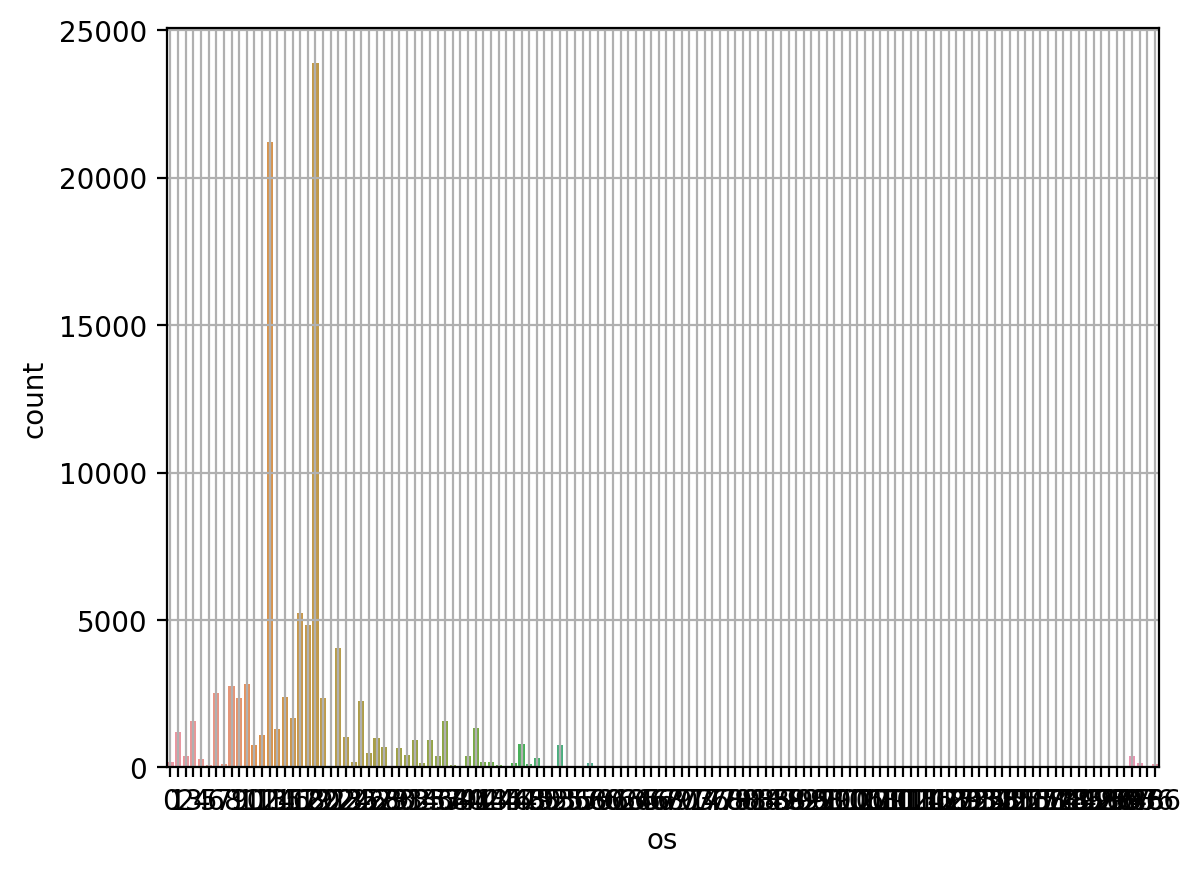

count    99999.000000
mean       268.833368
std        129.724579
min          3.000000
25%        145.000000
50%        258.000000
75%        379.000000
max        498.000000
Name: channel, dtype: float64

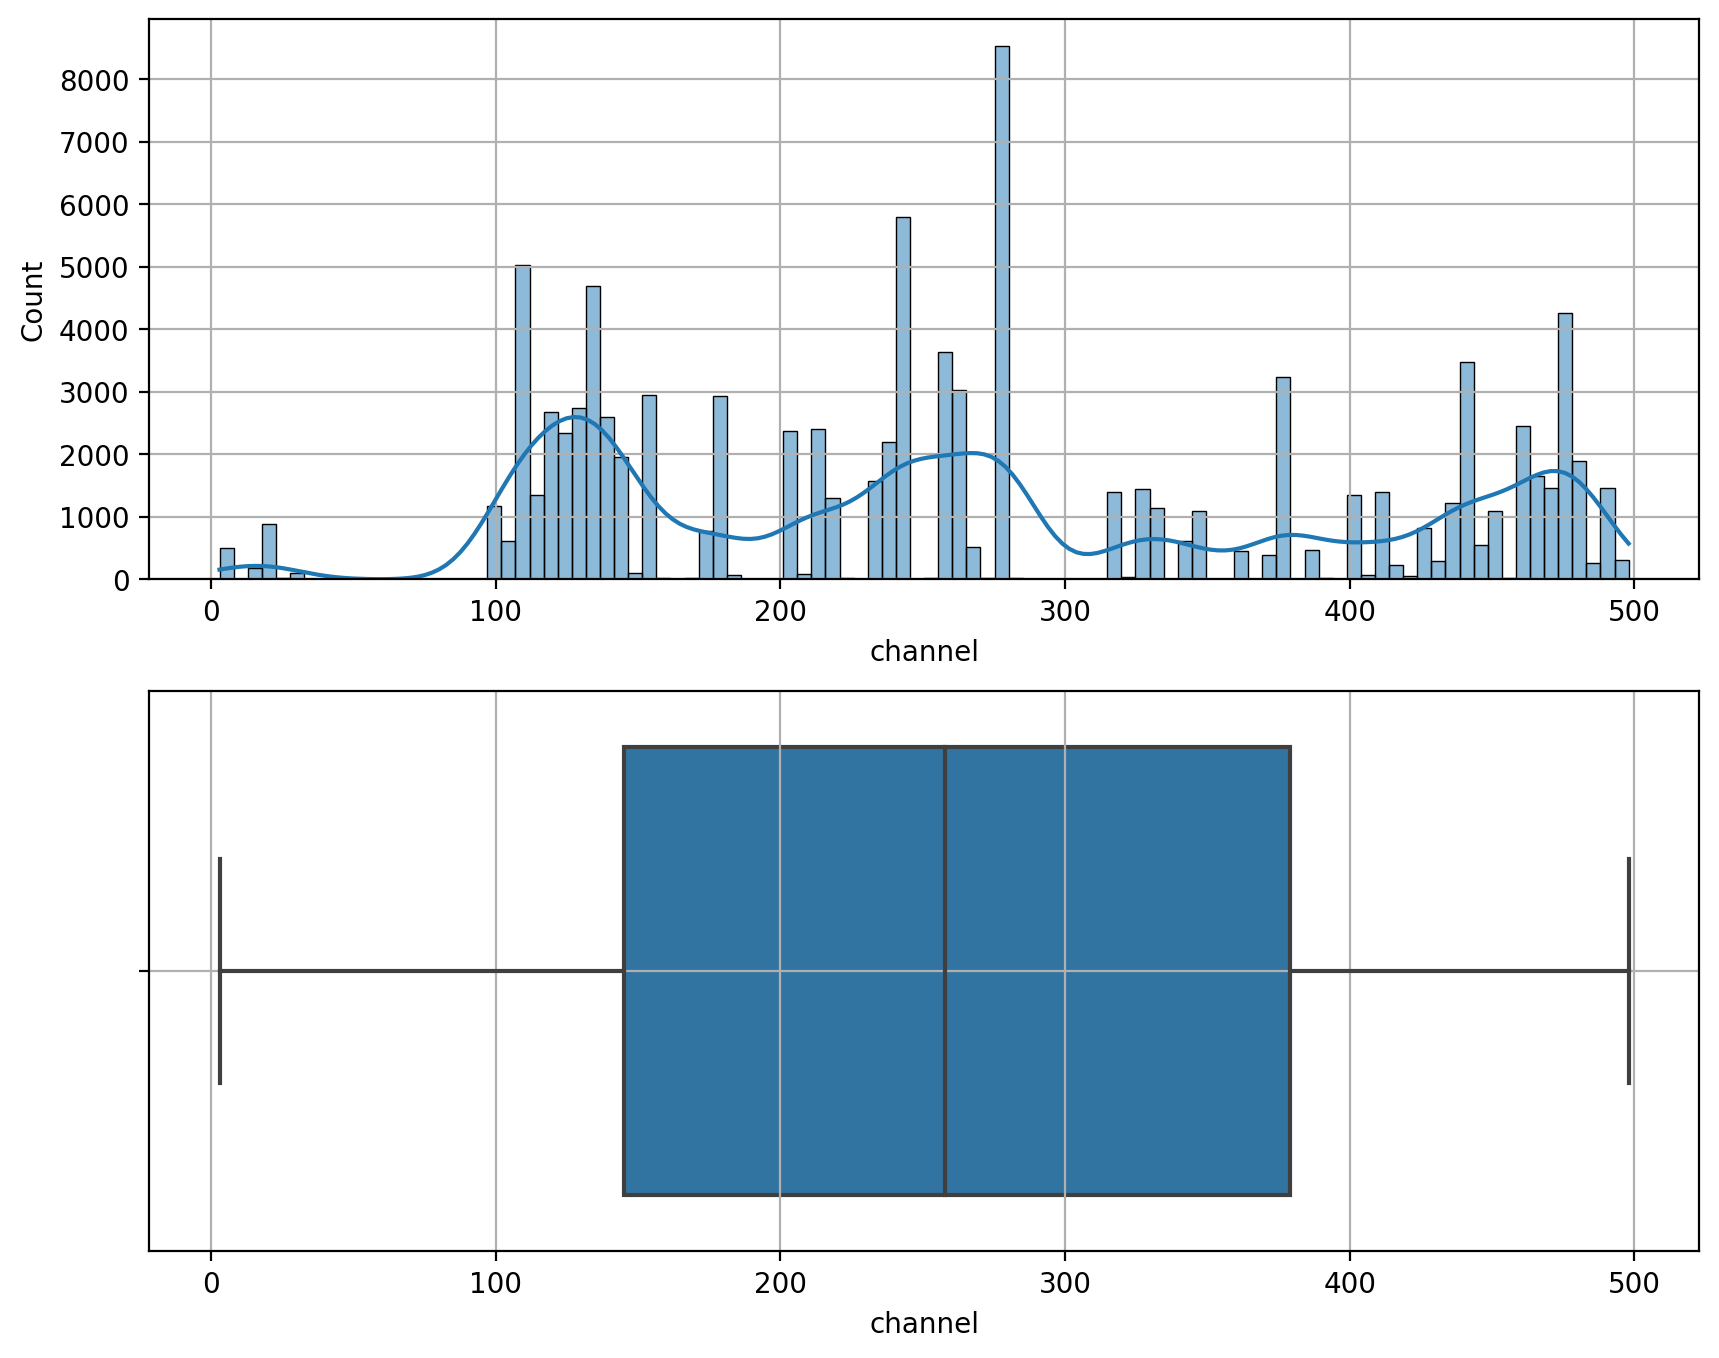

,count,ratio
280,8114,0.081141
245,4802,0.048020
107,4543,0.045430
477,3960,0.039600
134,3224,0.032240
...,...,...
114,1,0.000010
474,1,0.000010
261,1,0.000010
465,1,0.000010


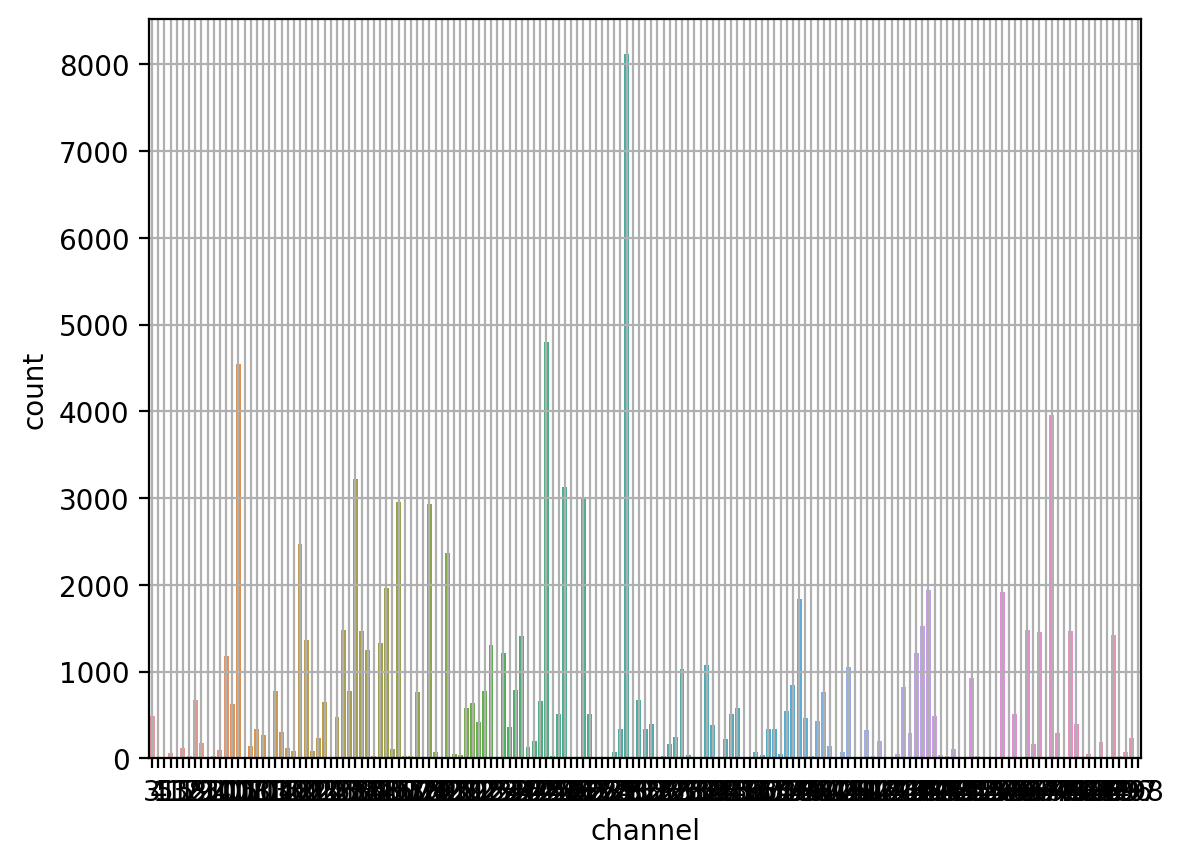

,count,ratio
0,99772,0.99773
1,227,0.00227


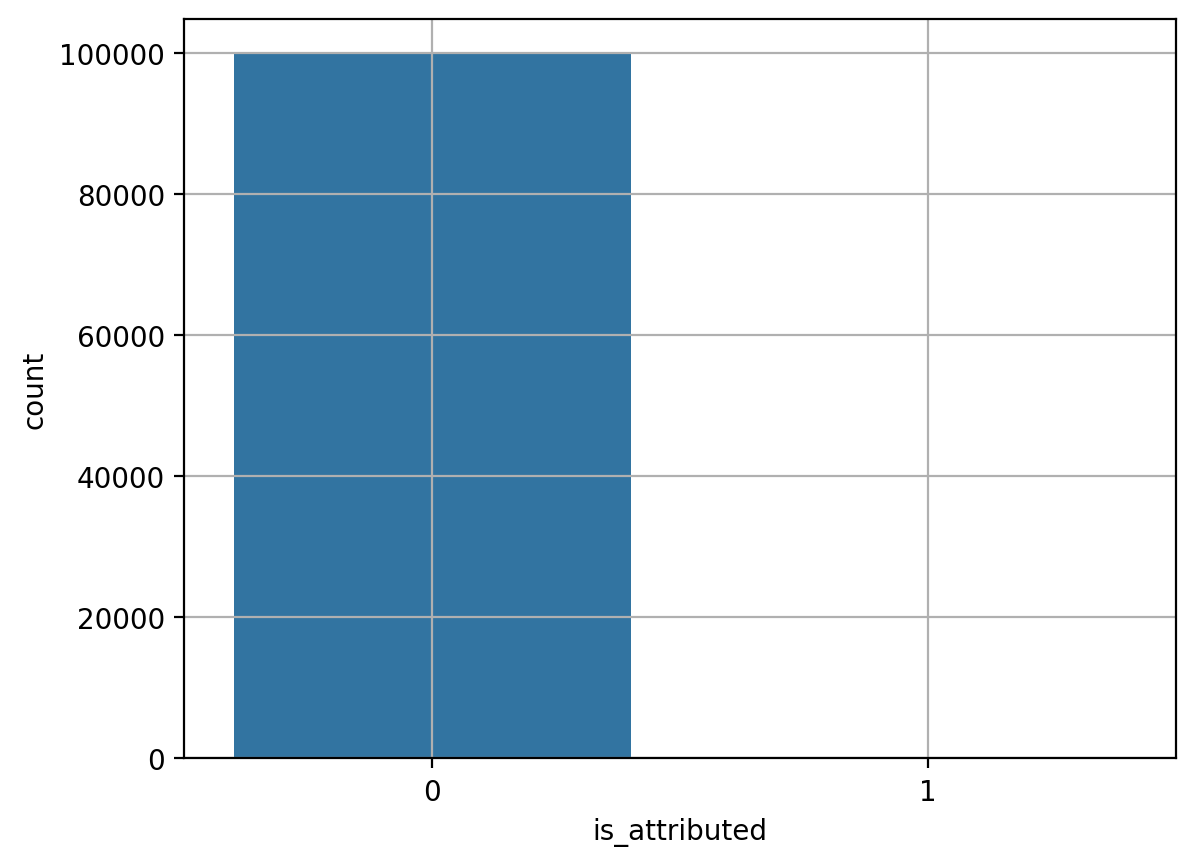

,count,ratio
8,34034,0.340343
7,32393,0.323933
9,28561,0.285613
6,5011,0.050111


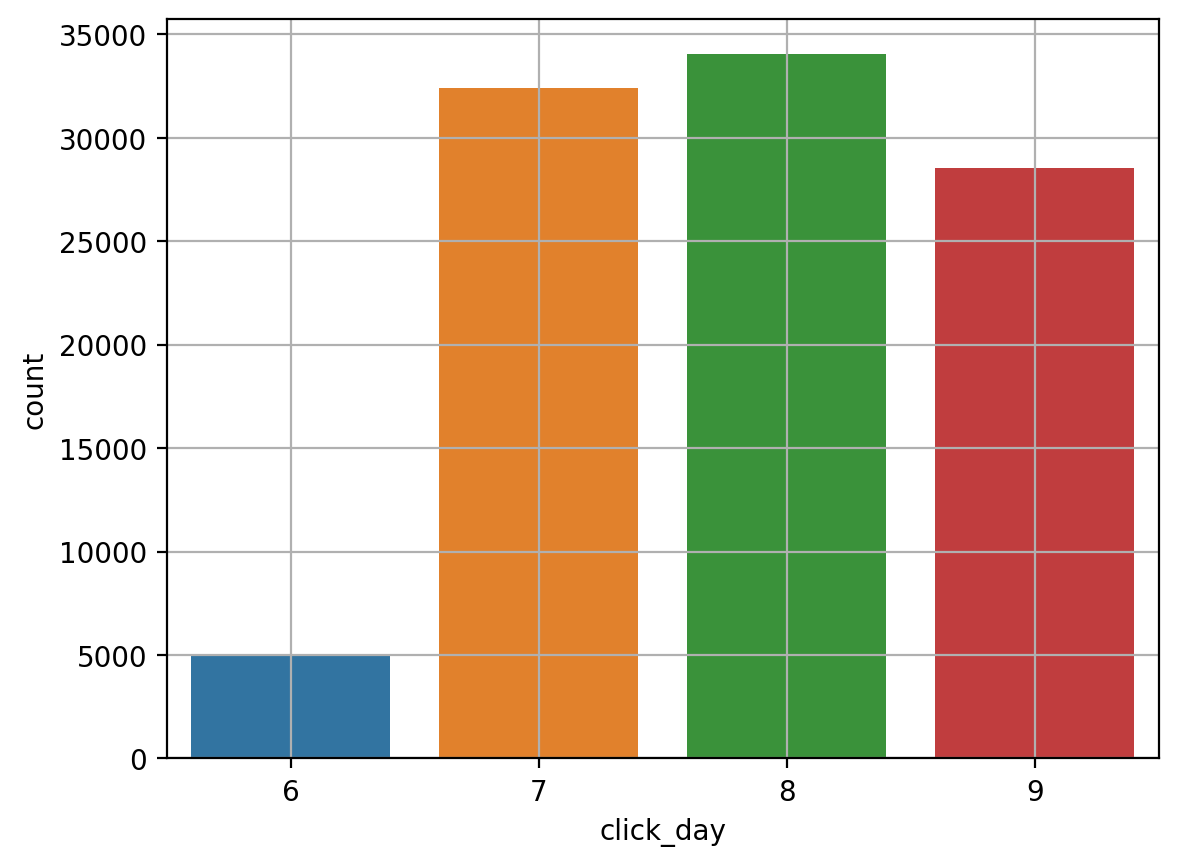

,count,ratio
4,6039,0.060391
0,5654,0.056541
13,5619,0.056191
14,5561,0.055611
10,5510,0.055101
5,5400,0.054001
11,5342,0.053421
12,5326,0.053261
3,5264,0.052641
2,5137,0.051371


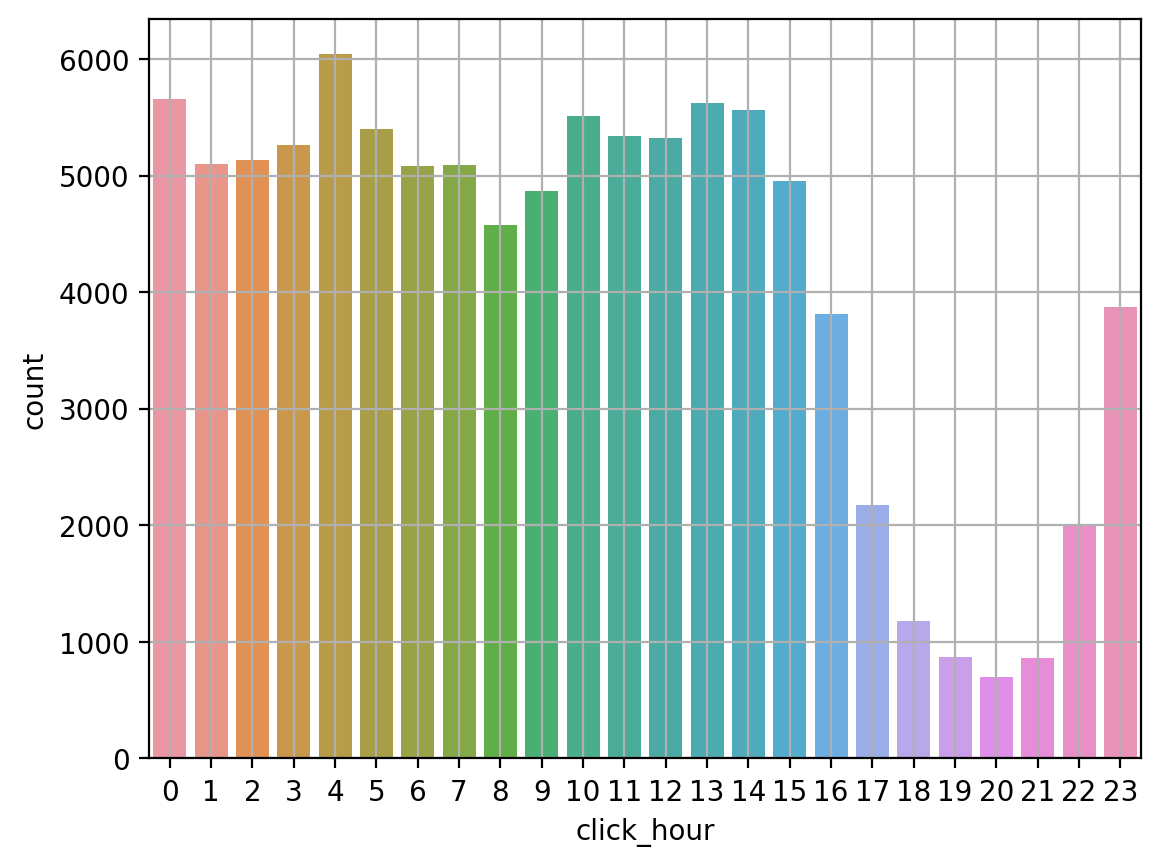

In [19]:
# 이상치 확인
# 데이터 분포 확인
# 컬럼 : 	app	device	os	channel	is_attributed	click_time_enc	click_day	click_hour	click_nmae

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
%config InlineBackend.figure_format='retina'

def eda_1_n(data, var):
    display(data[var].describe().T)
    plt.figure(figsize = (10,8))
    plt.subplot(2,1,1)
    sns.histplot(x = var, data = data, bins = 100, kde = True)
    plt.grid()

    plt.subplot(2,1,2)
    sns.boxplot(x = var, data = data)
    plt.grid()
    plt.show()

def eda_1_c(data, var):
    temp1 = data[var].value_counts()
    temp2 = data[var].value_counts()/data.shape[0]
    display(pd.DataFrame({'count':temp1, 'ratio': temp2}))

    sns.countplot(x = var, data = data)
    plt.grid()
    plt.show()

eda_1_n(data, 'app')
eda_1_c(data, 'app')
eda_1_n(data, 'device')
eda_1_c(data, 'device')
eda_1_n(data, 'os')
eda_1_c(data, 'os')
eda_1_n(data, 'channel')
eda_1_c(data, 'channel')
eda_1_c(data, 'is_attributed')
eda_1_c(data, 'click_day')
eda_1_c(data, 'click_hour')
# eda_1_c(data, 'click_nmae')

In [20]:
ip = data['ip'].value_counts()
ip=pd.DataFrame(ip)
ip

,ip
5348,669
5314,616
73487,439
73516,399
53454,280
...,...
109522,1
140527,1
351154,1
195068,1


In [21]:
 ip = data['ip'].value_counts()
app = data['app'].value_counts()
device = data['device'].value_counts()
os = data['os'].value_counts()
channel = data['channel'].value_counts()
click_day = data['click_day'].value_counts()
click_hour = data['click_hour'].value_counts()

ip1 = data['ip'].value_counts(normalize=True)
app1 = data['app'].value_counts(normalize=True)
device1 = data['device'].value_counts(normalize=True)
os1 = data['os'].value_counts(normalize=True)
channel1 = data['channel'].value_counts(normalize=True)
click_day1 = data['click_day'].value_counts(normalize=True)
click_hour1 = data['click_hour'].value_counts(normalize=True)


click_hour1.nlargest(40)

4     0.060391
0     0.056541
13    0.056191
14    0.055611
10    0.055101
5     0.054001
11    0.053421
12    0.053261
3     0.052641
2     0.051371
1     0.051031
7     0.050891
6     0.050791
15    0.049570
9     0.048670
8     0.045760
23    0.038700
16    0.038120
17    0.021760
22    0.020020
18    0.011830
19    0.008700
21    0.008640
20    0.006990
Name: click_hour, dtype: float64

(8.0, 0.0)

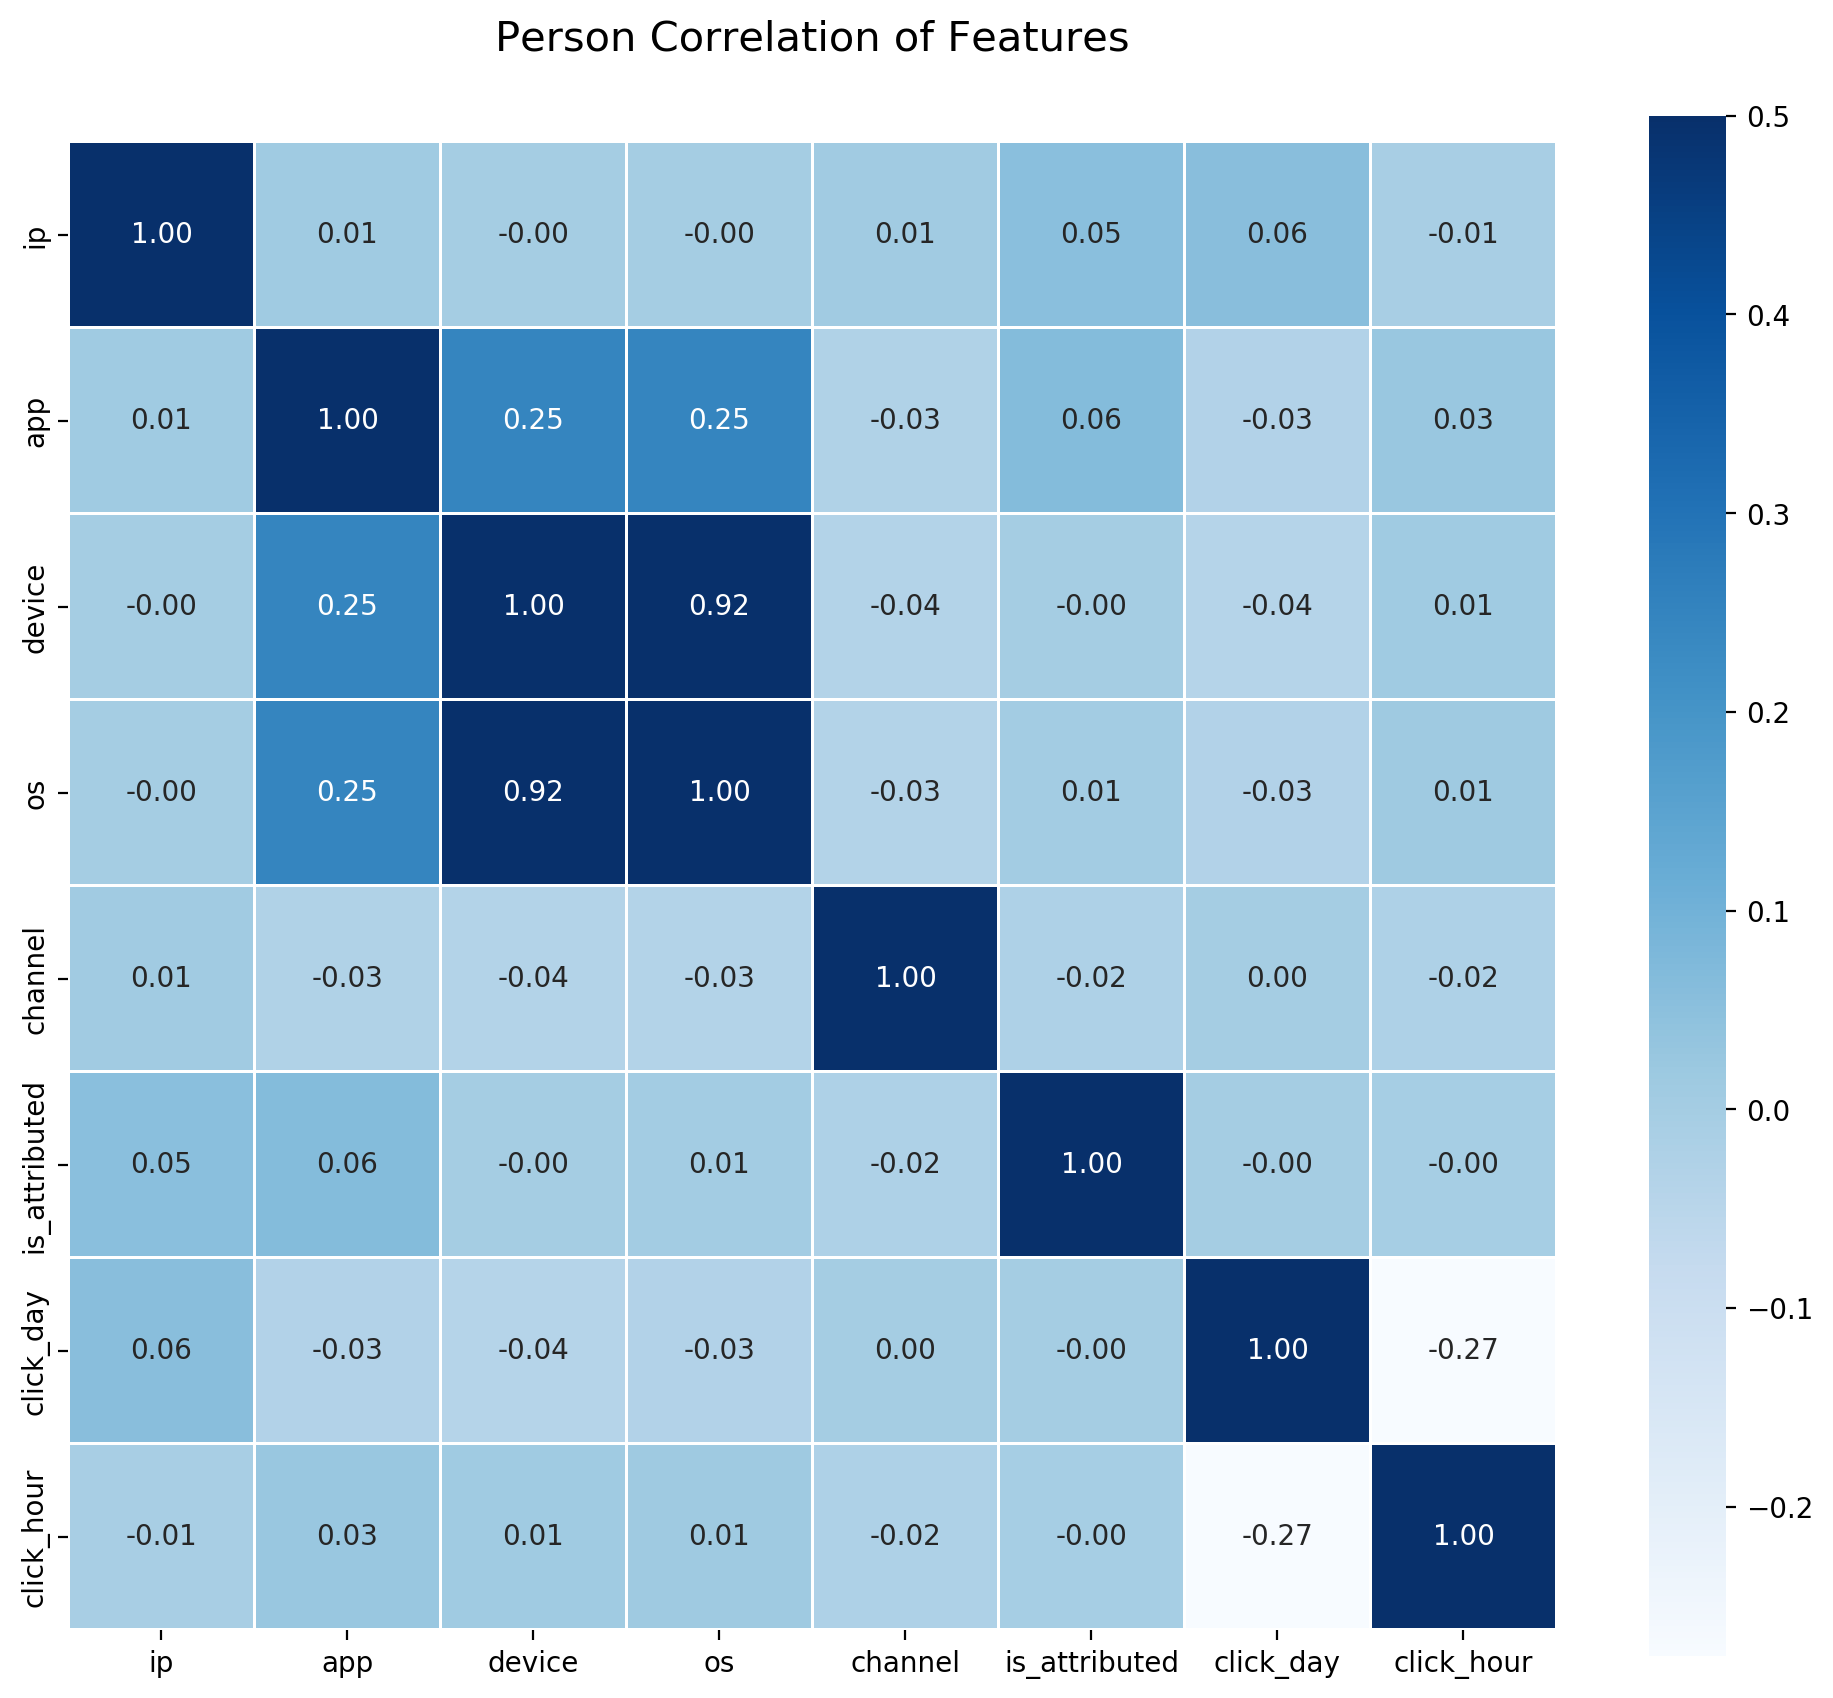

In [22]:
plt.figure(figsize=(12,10))
plt.title("Person Correlation of Features", y = 1.05, size = 15)


ax = sns.heatmap(data.corr(), linewidths = 0.5, vmax = 0.5, fmt=".2f",
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 10})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


(7.0, 0.0)

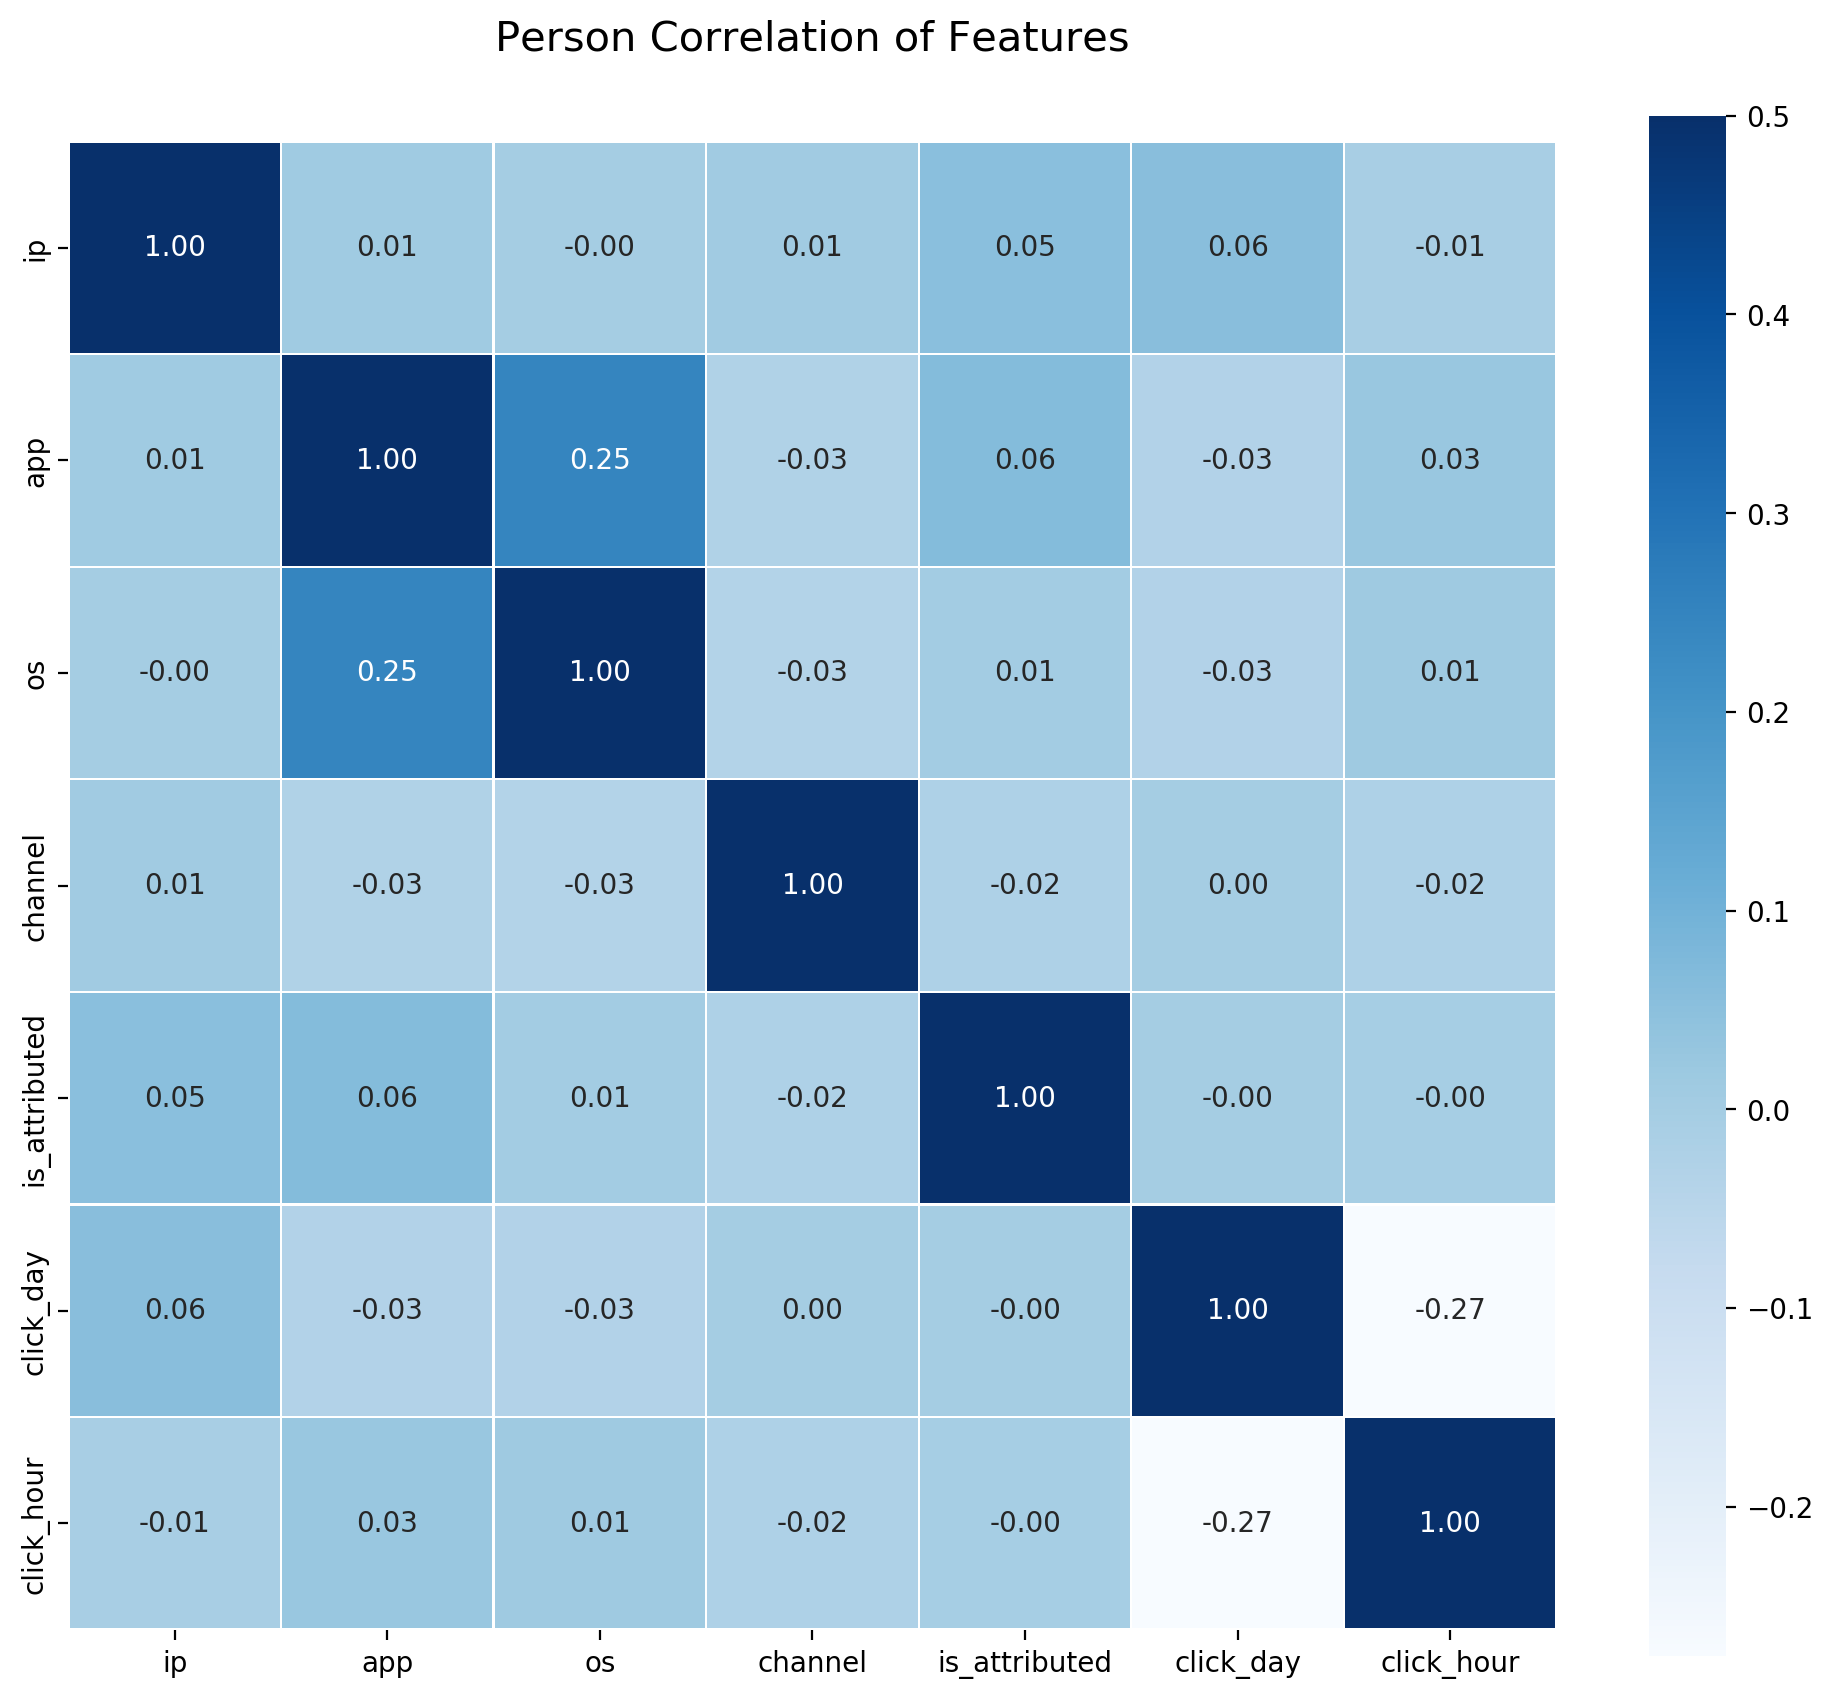

In [23]:
# OS나 디바이스 삭제 필요!!! - 다중공선성 의심..! - 데이터프레임 2개로 각각 나눠서 보자 그럼
data_os = data.drop('device',axis=1)
data_dv = data.drop('os',axis=1)

#os 상관관계
plt.figure(figsize=(12,10))
plt.title("Person Correlation of Features", y = 1.05, size = 15)


ax = sns.heatmap(data_os.corr(), linewidths = 0.5, vmax = 0.5, fmt=".2f",
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 10})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

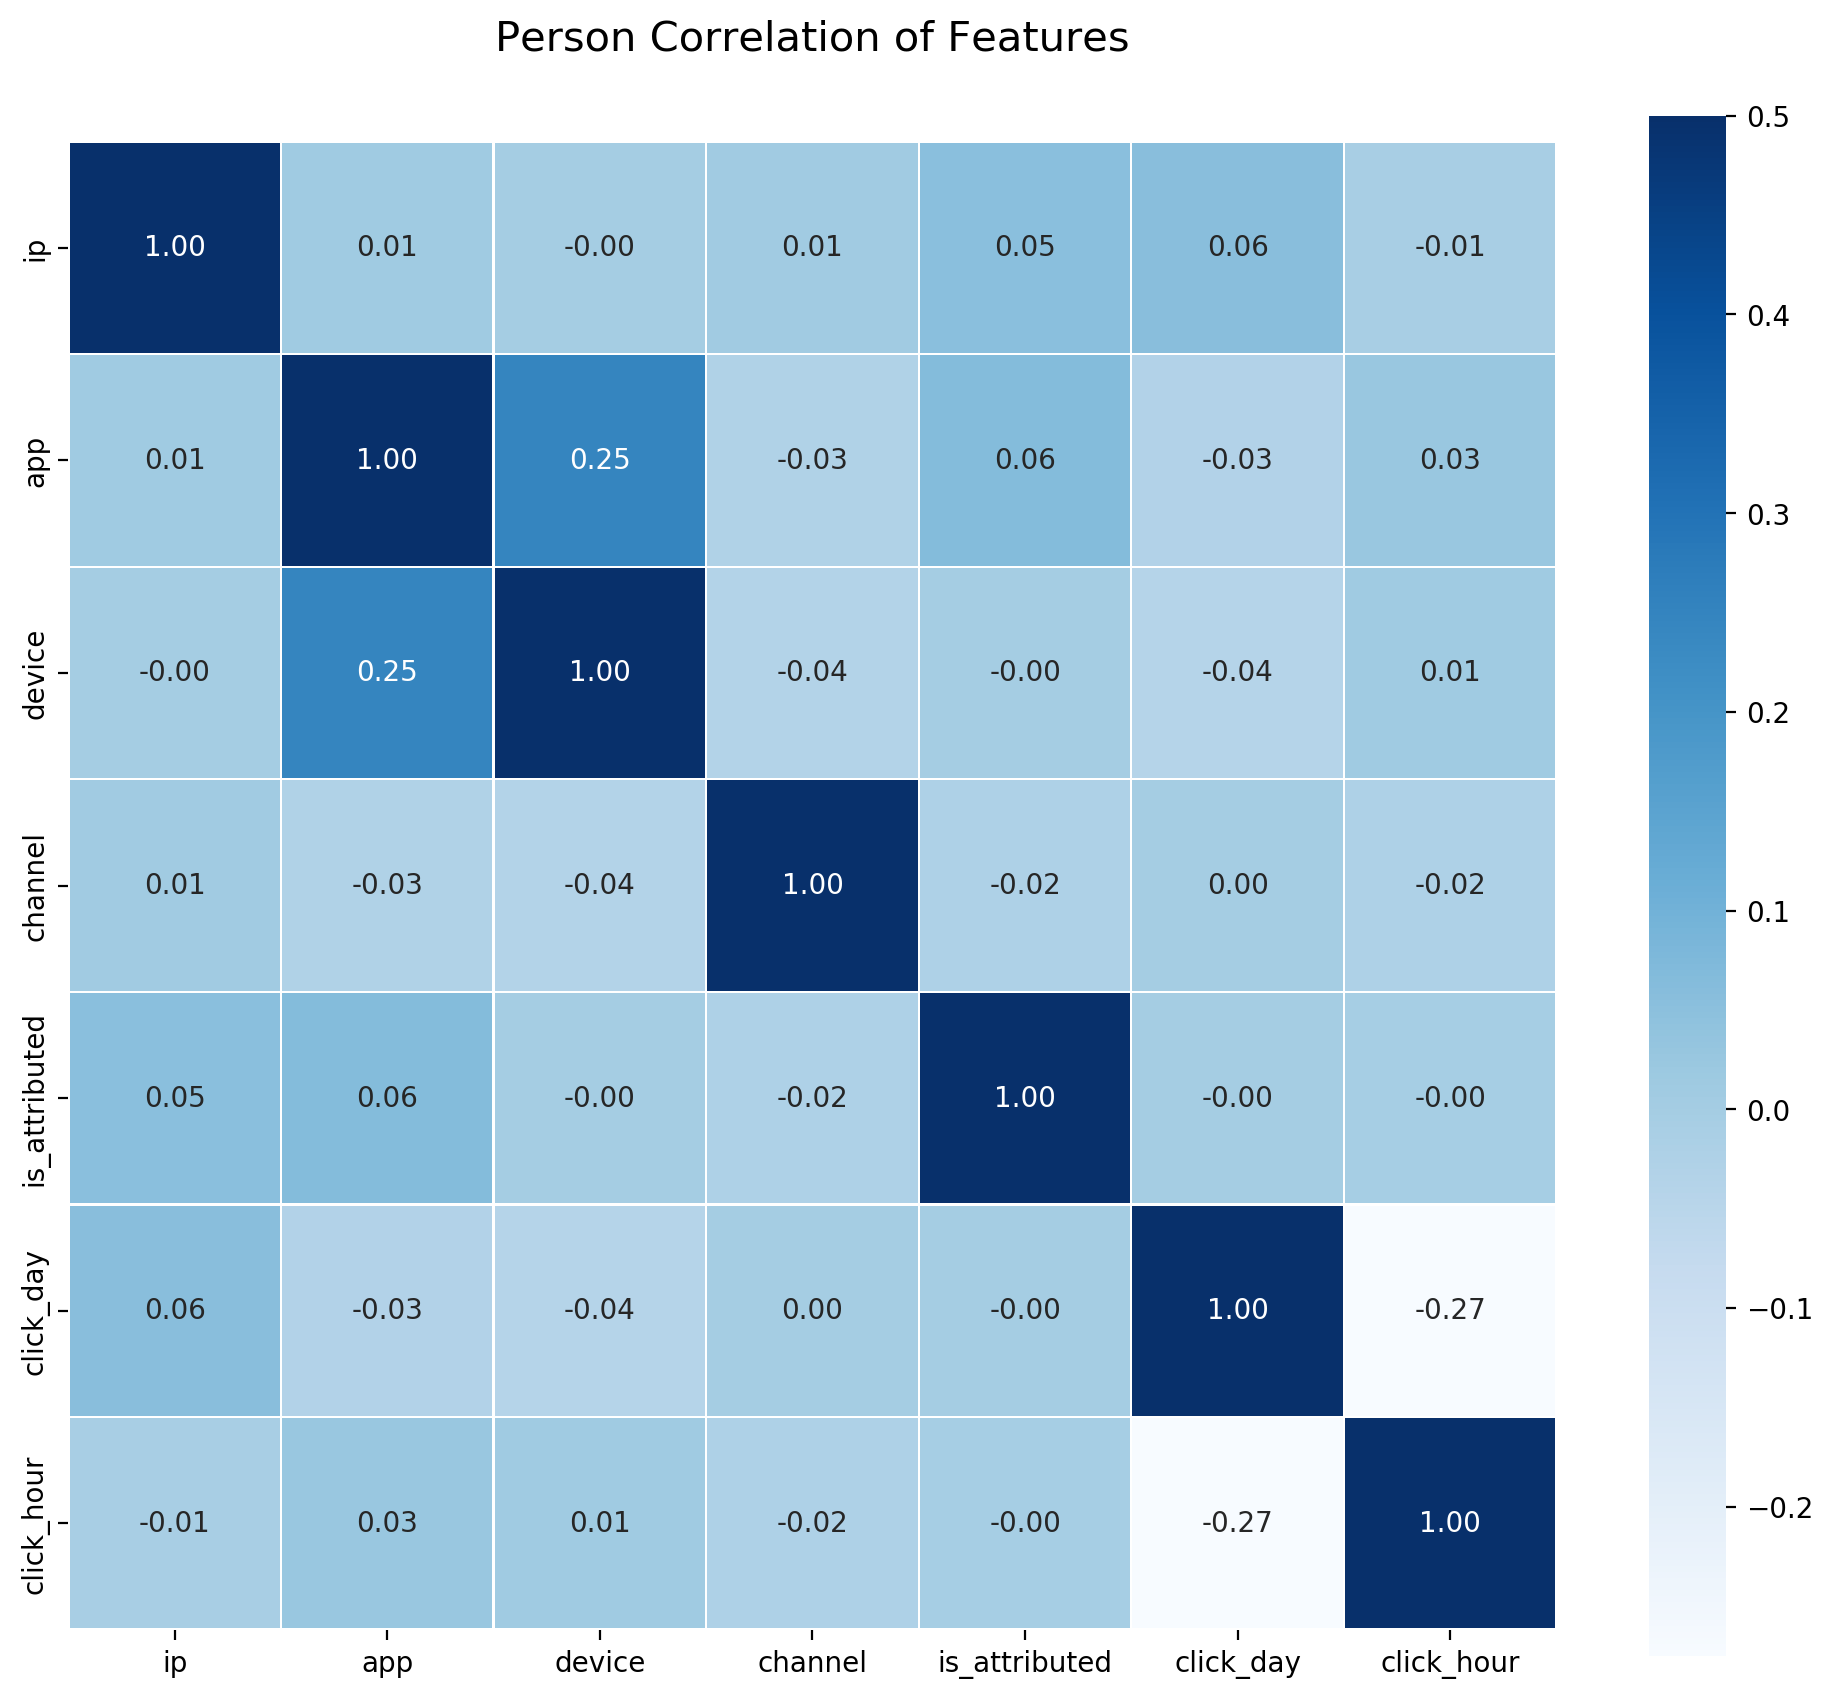

In [24]:
#device 상관관계
plt.figure(figsize=(12,10))
plt.title("Person Correlation of Features", y = 1.05, size = 15)


ax = sns.heatmap(data_dv.corr(), linewidths = 0.5, vmax = 0.5, fmt=".2f",
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 10})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


# 디바이스나 os가 거기서 거기인 것으로 확인. 그럼 카디널리티가 작은 os 기준으로 데이터 진행!
# + 클릭 시간과 nmae는 겹치는 놈임....! 따라서 df1과 df2로 나눠서, df1은 클릭시간, df2는 클릭 name가 포함된 데이터프레임으로 선언하고, 각각을 분석하자??
# => 걍 클릭시간만 보자 -_-
df1 = data_os
# df2 = data_os.drop('click_hour', axis=1)


In [25]:
from sklearn.model_selection import train_test_split

feature1 = df1.drop('is_attributed', axis=1)
target1 = df1['is_attributed']


# 타겟 데이터 엄청난 차이가 나옴!!!!
target1.value_counts(normalize=True)

0    0.99773
1    0.00227
Name: is_attributed, dtype: float64

In [26]:
import graphviz 
from sklearn.tree import export_graphviz 
from sklearn.ensemble import RandomForestClassifier 
from category_encoders import OrdinalEncoder 
from sklearn.impute import SimpleImputer 
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *



# 분류모델을 써야 하는데, 범주형 데이터가 많아서 트리 기반 모델 쓰는게 맞음. 하나씩 써봄

# 타겟 데이터 비율 조정 안한 기준 모델 성능!

base =  make_pipeline(
         OrdinalEncoder(),
         XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            random_state=42)
        ) 

base.fit(feature1, target1)
pred = base.predict(feature1)

print('base model')
print(classification_report(target1, pred))


# print('train accuracy: ', base.score(X1_train, y1_train))
# print('val accuracy: ', base.score(X1_val, y1_val))

base model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99772
           1       0.99      0.86      0.92       227

    accuracy                           1.00     99999
   macro avg       1.00      0.93      0.96     99999
weighted avg       1.00      1.00      1.00     99999



In [27]:
###### 타겟 데이터 비율 조정!!!!!!!!!
from imblearn.under_sampling import RandomUnderSampler # down
from imblearn.over_sampling import RandomOverSampler, SMOTE  # up, smote

# Down sampling : 적은 쪽 클래스는 그대로, 많은 쪽 클래스는 랜덤 샘플링(적은쪽 클래수 수 만큼)
rus = RandomUnderSampler(random_state = 4)
x_d, y_d = rus.fit_resample(feature1, target1)


model_down =XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            random_state=42)
model_down.fit(x_d,y_d)


pred = model_down.predict(feature1)

print(confusion_matrix(target1, pred))
print('=' * 60)
print(classification_report(target1, pred))

[[92358  7414]
 [    0   227]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     99772
           1       0.03      1.00      0.06       227

    accuracy                           0.93     99999
   macro avg       0.51      0.96      0.51     99999
weighted avg       1.00      0.93      0.96     99999



In [28]:
# Up sampling : 많은 클래스는 그대로, 적은 클래스는 랜덤 복원추출(많은 클래스 만큼)
ros = RandomOverSampler(random_state = 4)
x_u, y_u = ros.fit_resample(feature1, target1)

model_up =XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            random_state=42)
model_up.fit(x_u,y_u)


pred = model_up.predict(feature1)

print(confusion_matrix(target1, pred))
print('=' * 60)
print(classification_report(target1, pred))

from sklearn.metrics import roc_auc_score

y_pred_proba = model_up.predict_proba(feature1)[:,1]

auc = roc_auc_score(target1, y_pred_proba)
print(f"auc score : {auc.round(3)}")

[[99618   154]
 [    0   227]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99772
           1       0.60      1.00      0.75       227

    accuracy                           1.00     99999
   macro avg       0.80      1.00      0.87     99999
weighted avg       1.00      1.00      1.00     99999

auc score : 1.0


In [29]:
# SMOTE : 많은쪽은 그대로(혹은 약간 down sampling), 적은쪽은 보간법!

smote = SMOTE(random_state = 4) 
x_sm, y_sm = smote.fit_resample(feature1, target1)


model_sm =XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            random_state=42)
model_sm.fit(x_sm,y_sm)


pred = model_sm.predict(feature1)

print(confusion_matrix(target1, pred))
print('=' * 60)
print(classification_report(target1, pred))

from sklearn.metrics import roc_auc_score

y_pred_proba = model_sm.predict_proba(feature1)[:,1]

auc = roc_auc_score(target1, y_pred_proba)
print(f"auc score : {auc.round(3)}")

[[99428   344]
 [   19   208]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99772
           1       0.38      0.92      0.53       227

    accuracy                           1.00     99999
   macro avg       0.69      0.96      0.77     99999
weighted avg       1.00      1.00      1.00     99999

auc score : 0.998


In [30]:
#train/val/test 나누기

X_train, X_test, y_train, y_test = train_test_split(feature1, target1, stratify=target1, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

# X2_train, X2_test, y1_train, y2_test = train_test_split(feature1, target1, stratify=target1, test_size=0.25, random_state=42)
# X2_train, X2_val, y1_train, y2_val = train_test_split(feature1, target1, stratify=target1, test_size=0.25, random_state=42)

In [31]:
print(X_train.shape, X_val.shape)
print(y_train.value_counts(normalize=True))

(56249, 6) (18750, 6)
0    0.997742
1    0.002258
Name: is_attributed, dtype: float64


In [32]:
from sklearn.ensemble import IsolationForest # Isolation Forest!
model = IsolationForest(contamination=0.002258)
model.fit(X_train)

# 예측
pred = model.predict(X_val)

# 결과를 1,0으로 변환(np.where)
pred = np.where( pred == 1  , 0 , 1  )

# 분류 결과를 평가해 봅시다.
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[18656    51]
 [   43     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18707
           1       0.00      0.00      0.00        43

    accuracy                           0.99     18750
   macro avg       0.50      0.50      0.50     18750
weighted avg       1.00      0.99      1.00     18750



In [33]:
# 가장 성능 좋은 건, SMOTE!
# SMOTE 기준으로 진행

x_sm, y_sm = smote.fit_resample(X_train, y_train)

base =  XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            random_state=42)


base.fit(x_sm,y_sm)

pred = base.predict(X_train)
pred1 = base.predict(X_val)


print('baseline model : train evaluation')
print(confusion_matrix(y_train, pred))
print('=' * 60)
print(classification_report(y_train, pred))
print('baseline model : val evaluation')
print(confusion_matrix(y_val, pred1))
print('=' * 60)
print(classification_report(y_val, pred1))

y_pred_proba1 = base.predict_proba(X_train)[:,1]
y_pred_proba2 = base.predict_proba(X_val)[:,1]

auc1 = roc_auc_score(y_train, y_pred_proba1)
auc2 = roc_auc_score(y_val, y_pred_proba2)

print(f"train - auc score : {auc1.round(3)}")
print(f"val - auc score : {auc2.round(3)}")

baseline model : train evaluation
[[56012   110]
 [   10   117]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56122
           1       0.52      0.92      0.66       127

    accuracy                           1.00     56249
   macro avg       0.76      0.96      0.83     56249
weighted avg       1.00      1.00      1.00     56249

baseline model : val evaluation
[[18598   109]
 [   20    23]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18707
           1       0.17      0.53      0.26        43

    accuracy                           0.99     18750
   macro avg       0.59      0.76      0.63     18750
weighted avg       1.00      0.99      0.99     18750

train - auc score : 0.999
val - auc score : 0.927


In [34]:
### xgboost
y_pred_train = base.predict(X_train)
y_pred_val = base.predict(X_val)
y_pred_test = base.predict(X_test)

print('base : train evaluation')
print(classification_report(y_train, y_pred_train))
print('base : val evaluation')
print(classification_report(y_val, y_pred_val))
print('base : test evaluation')
print(classification_report(y_test, y_pred_test))

y_pred_proba1 = base.predict_proba(X_train)[:,1]
y_pred_proba2 = base.predict_proba(X_val)[:,1]
y_pred_proba3 = base.predict_proba(X_test)[:,1]

auc1 = roc_auc_score(y_train, y_pred_proba1)
auc2 = roc_auc_score(y_val, y_pred_proba2)
auc3 = roc_auc_score(y_test, y_pred_proba3)

print(f"train - auc score : {auc1.round(3)}")
print(f"val - auc score : {auc2.round(3)}")
print(f"test - auc score : {auc3.round(3)}")

base : train evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56122
           1       0.52      0.92      0.66       127

    accuracy                           1.00     56249
   macro avg       0.76      0.96      0.83     56249
weighted avg       1.00      1.00      1.00     56249

base : val evaluation
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18707
           1       0.17      0.53      0.26        43

    accuracy                           0.99     18750
   macro avg       0.59      0.76      0.63     18750
weighted avg       1.00      0.99      0.99     18750

base : test evaluation
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     24943
           1       0.19      0.54      0.28        57

    accuracy                           0.99     25000
   macro avg       0.59      0.77      0.64     25000
we

In [35]:
y_sm.value_counts()

0    56122
1    56122
Name: is_attributed, dtype: int64

In [36]:
###### 모델 비교 및 최종 선택

In [37]:
#랜덤포레스트
rf1 =    RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1)

rf1.fit(x_sm,y_sm)
y_pred_train = rf1.predict(X_train)
y_pred_val = rf1.predict(X_val)
y_pred_test = rf1.predict(X_test)

print('rf : train evaluation')
print(classification_report(y_train, y_pred_train))
print('rf : val evaluation')
print(classification_report(y_val, y_pred_val))
print('rf : test evaluation')
print(classification_report(y_test, y_pred_test))

y_pred_proba1 = rf1.predict_proba(X_train)[:,1]
y_pred_proba2 = rf1.predict_proba(X_val)[:,1]
y_pred_proba3 = rf1.predict_proba(X_test)[:,1]


auc1 = roc_auc_score(y_train, y_pred_proba1)
auc2 = roc_auc_score(y_val, y_pred_proba2)
auc3 = roc_auc_score(y_test, y_pred_proba3)

print(f"train - auc score : {auc1.round(3)}")
print(f"val - auc score : {auc2.round(3)}")
print(f"test - auc score : {auc3.round(3)}")

rf : train evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56122
           1       1.00      1.00      1.00       127

    accuracy                           1.00     56249
   macro avg       1.00      1.00      1.00     56249
weighted avg       1.00      1.00      1.00     56249

rf : val evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18707
           1       0.18      0.40      0.25        43

    accuracy                           0.99     18750
   macro avg       0.59      0.70      0.62     18750
weighted avg       1.00      0.99      1.00     18750

rf : test evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24943
           1       0.21      0.40      0.28        57

    accuracy                           1.00     25000
   macro avg       0.61      0.70      0.64     25000
weighted av

In [38]:
from sklearn.model_selection import GridSearchCV

# xgb모델로 돌려보기 + 그리드 서치 + 조기종료(50)??

xgb = XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            random_state=42,
            n_jobs=-1,
            learning_rate=0.1)


params = {
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__n_estimators": [100, 150, 200],
}



# watchlist = [(X_train, y_train), (X_val, y_val)]

# model.fit(
#     X_train,
#     y_train,
#     eval_set=watchlist,
#     early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
# )



grid_search = GridSearchCV(xgb, param_grid=params, scoring="f1", cv=3, verbose=3)
grid_search.fit(x_sm,y_sm)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[04:50:29] WARNING: ../src/learner.cc:767: 
Parameters: { "xgbclassifier__max_depth", "xgbclassifier__min_child_weight", "xgbclassifier__n_estimators" } are not used.

[CV 1/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=100;, score=0.988 total time=   4.0s
[04:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "xgbclassifier__max_depth", "xgbclassifier__min_child_weight", "xgbclassifier__n_estimators" } are not used.

[CV 2/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=100;, score=0.988 total time=   5.7s
[04:50:39] WARNING: ../src/learner.cc:767: 
Parameters: { "xgbclassifier__max_depth", "xgbclassifier__min_child_weight", "xgbclassifier__n_estimators" } are not used.

[CV 3/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=100;, score=0.988 total time=   5.8s
[04:50:44] W

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='error', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0....
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'xgbclassifier__max_depth': [2, 4, 6],
                         'xgbclassifier__min_child_weight': [2, 4, 8],
                         'xgbclassifier__n_estimators': [100, 150, 200]},
             scoring='f1', verbose=3)

In [39]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 AUC: ", grid_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__n_estimators': 100}
최적 AUC:  0.9878386512668941


In [40]:
xgb = XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            max_depth = 2,
            min_child_weight = 2,
            learning_rate=0.1)




xgb.fit(x_sm,y_sm)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

print('xgb : train evaluation')
print(classification_report(y_train, y_pred_train))
print('xgb : val evaluation')
print(classification_report(y_val, y_pred_val))


y_pred_proba1 = xgb.predict_proba(X_train)[:,1]
y_pred_proba2 = xgb.predict_proba(X_val)[:,1]

auc1 = roc_auc_score(y_train, y_pred_proba1)
auc2 = roc_auc_score(y_val, y_pred_proba2)

print(f"train - auc score : {auc1.round(3)}")
print(f"val - auc score : {auc2.round(3)}")

xgb : train evaluation
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56122
           1       0.02      0.80      0.04       127

    accuracy                           0.91     56249
   macro avg       0.51      0.85      0.49     56249
weighted avg       1.00      0.91      0.95     56249

xgb : val evaluation
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     18707
           1       0.02      0.84      0.04        43

    accuracy                           0.91     18750
   macro avg       0.51      0.87      0.49     18750
weighted avg       1.00      0.91      0.95     18750

train - auc score : 0.936
val - auc score : 0.924


In [41]:
#기준모델

rf = RandomForestClassifier(n_estimators =200,random_state=42, oob_score=True, n_jobs=-1)


params = {
    "max_depth": [2, 4, 3],
    "min_samples_split": [2, 4, 3],
}



# watchlist = [(X_train, y_train), (X_val, y_val)]

# model.fit(
#     X_train,
#     y_train,
#     eval_set=watchlist,
#     early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
# )



grid_search = GridSearchCV(rf, param_grid=params, scoring="f1", cv=3, verbose=3)
grid_search.fit(x_sm,y_sm)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ..max_depth=2, min_samples_split=2;, score=0.862 total time=   5.2s
[CV 2/3] END ..max_depth=2, min_samples_split=2;, score=0.862 total time=   4.9s
[CV 3/3] END ..max_depth=2, min_samples_split=2;, score=0.859 total time=   4.2s
[CV 1/3] END ..max_depth=2, min_samples_split=4;, score=0.862 total time=   4.1s
[CV 2/3] END ..max_depth=2, min_samples_split=4;, score=0.862 total time=   5.0s
[CV 3/3] END ..max_depth=2, min_samples_split=4;, score=0.859 total time=   4.1s
[CV 1/3] END ..max_depth=2, min_samples_split=3;, score=0.862 total time=   4.1s
[CV 2/3] END ..max_depth=2, min_samples_split=3;, score=0.862 total time=   5.3s
[CV 3/3] END ..max_depth=2, min_samples_split=3;, score=0.859 total time=   4.1s
[CV 1/3] END ..max_depth=4, min_samples_split=2;, score=0.893 total time=   5.9s
[CV 2/3] END ..max_depth=4, min_samples_split=2;, score=0.891 total time=   6.3s
[CV 3/3] END ..max_depth=4, min_samples_split=2;,

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                              oob_score=True, random_state=42),
             param_grid={'max_depth': [2, 4, 3],
                         'min_samples_split': [2, 4, 3]},
             scoring='f1', verbose=3)

In [42]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 AUC: ", grid_search.best_score_)

최적 하이퍼파라미터:  {'max_depth': 4, 'min_samples_split': 2}
최적 AUC:  0.8919821410661299


In [43]:
#기준모델 검증
rf =    RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, max_depth = 4,
            min_samples_split = 2)

rf.fit(x_sm,y_sm)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)

print('rf : train evaluation')
print(classification_report(y_train, y_pred_train))
print('rf : val evaluation')
print(classification_report(y_val, y_pred_val))


y_pred_proba1 = rf.predict_proba(X_train)[:,1]
y_pred_proba2 = rf.predict_proba(X_val)[:,1]

auc1 = roc_auc_score(y_train, y_pred_proba1)
auc2 = roc_auc_score(y_val, y_pred_proba2)

print(f"train - auc score : {auc1.round(3)}")
print(f"val - auc score : {auc2.round(3)}")

rf : train evaluation
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56122
           1       0.02      0.83      0.03       127

    accuracy                           0.88     56249
   macro avg       0.51      0.85      0.48     56249
weighted avg       1.00      0.88      0.94     56249

rf : val evaluation
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     18707
           1       0.02      0.79      0.03        43

    accuracy                           0.88     18750
   macro avg       0.51      0.84      0.48     18750
weighted avg       1.00      0.88      0.93     18750

train - auc score : 0.926
val - auc score : 0.916


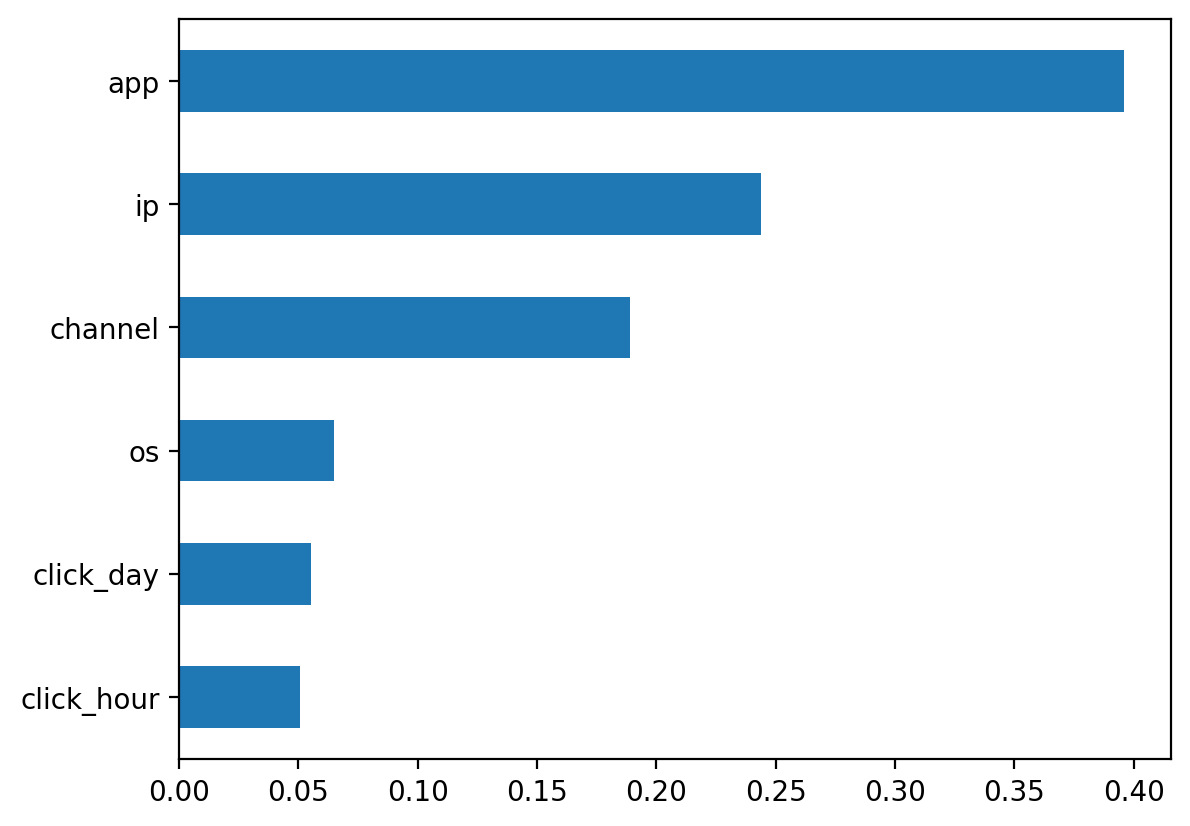

In [44]:
### 특성 중요도 살펴보기

%matplotlib inline
import matplotlib.pyplot as plt

# model_xgb = xgb.named_steps['xgbclassifier']
importances = pd.Series(rf1.feature_importances_, X_train.columns)
importances.sort_values().plot.barh();

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb441772880>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb441783760>})

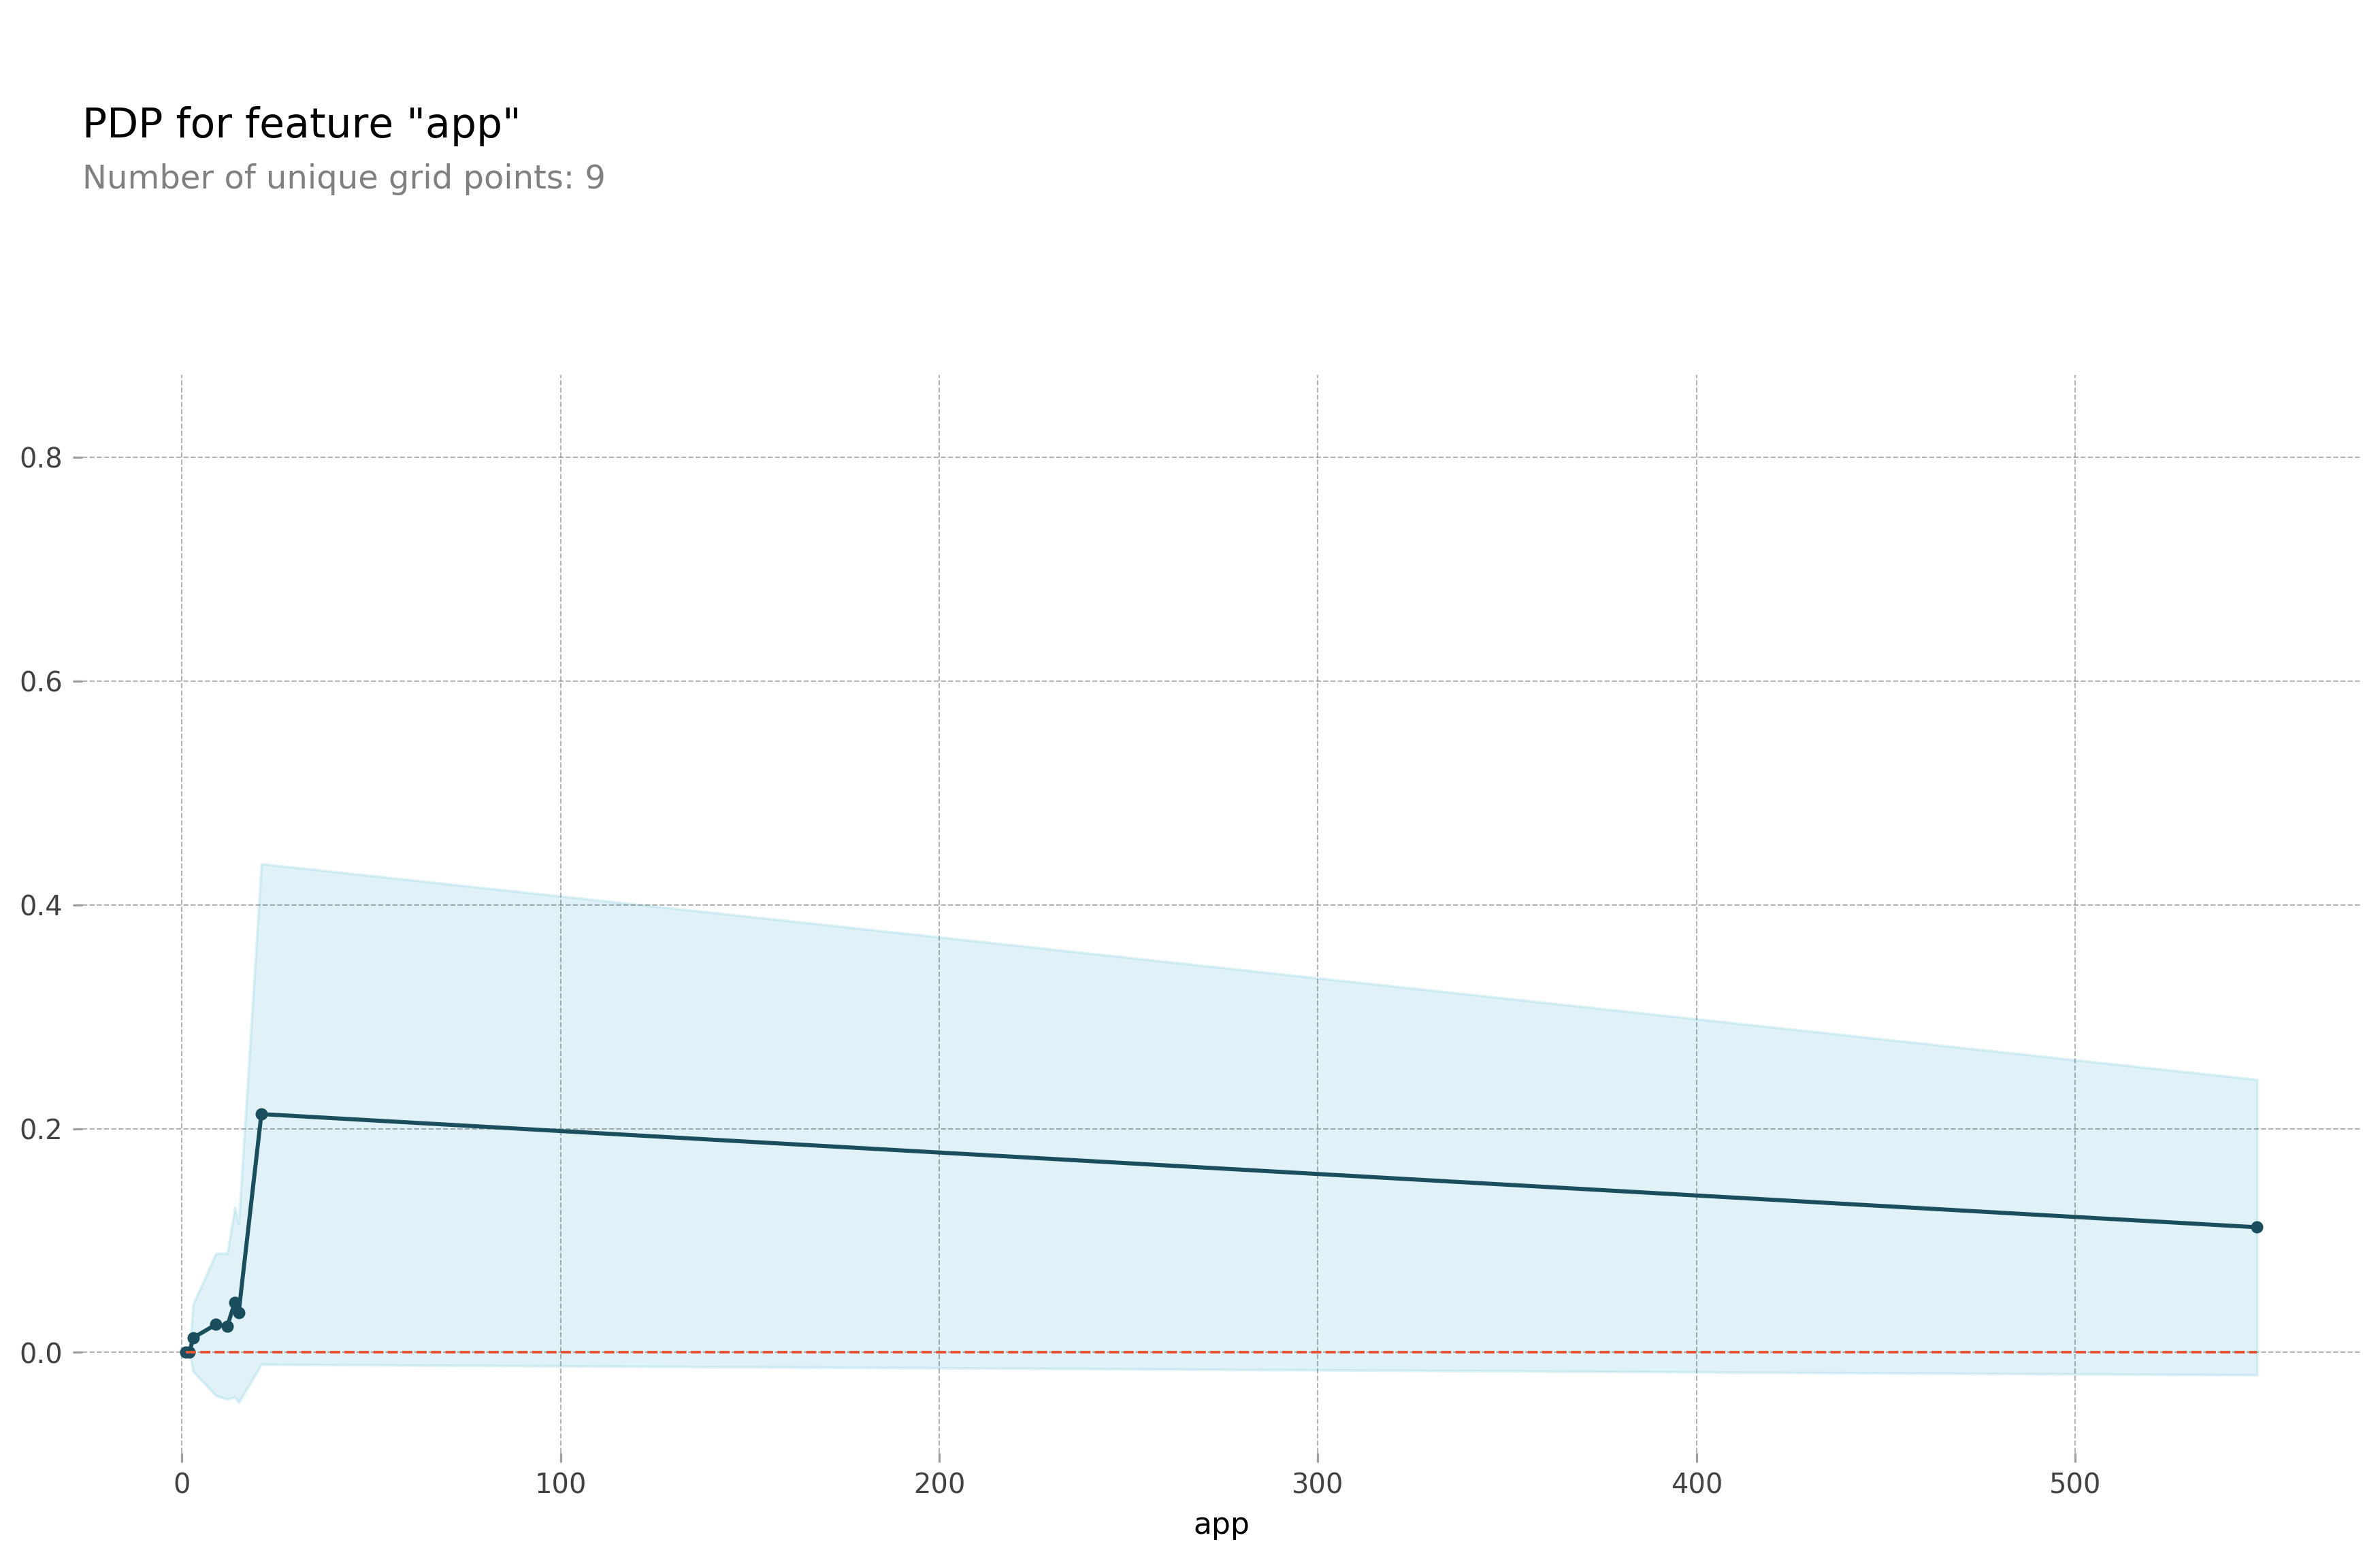

In [45]:
from tqdm import tqdm
from pdpbox.pdp import pdp_isolate, pdp_plot

plt.rcParams["figure.dpi"] = 144


target_feature = "app"

isolated = pdp_isolate(
    model=rf1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb4416ca3d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb4419208e0>})

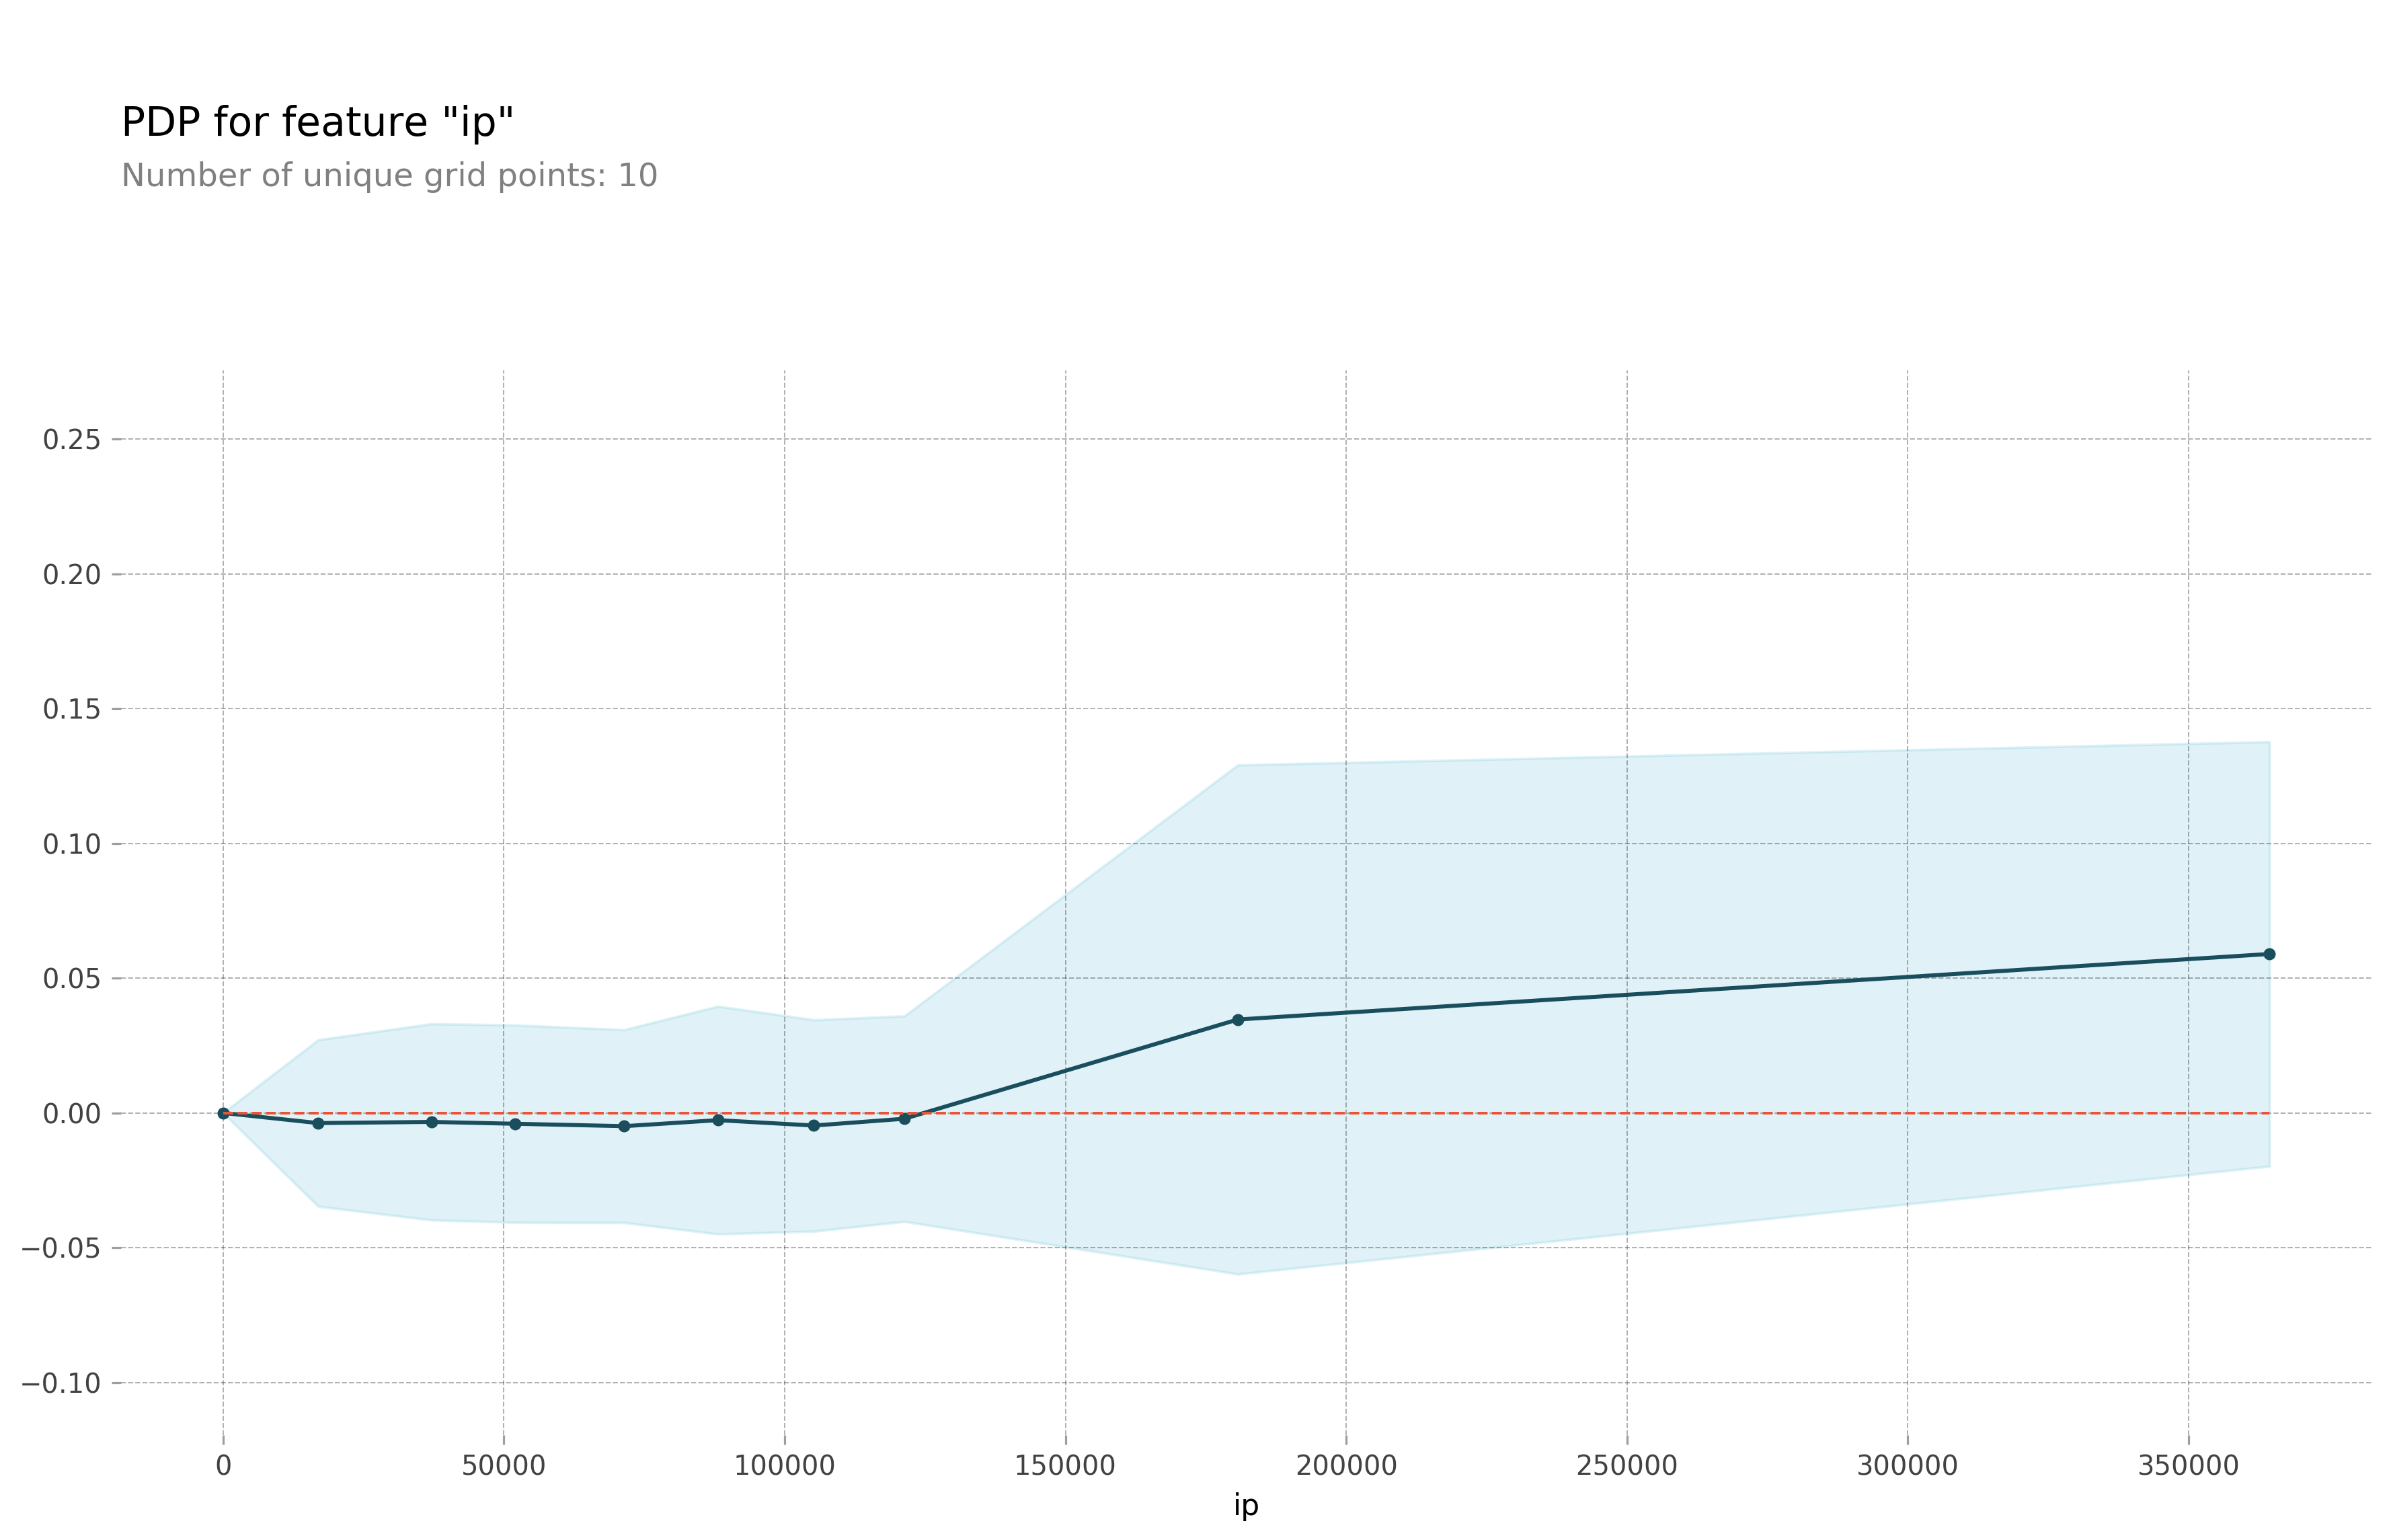

In [46]:
target_feature = "ip"

isolated = pdp_isolate(
    model=rf1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb4417fccd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb441911640>})

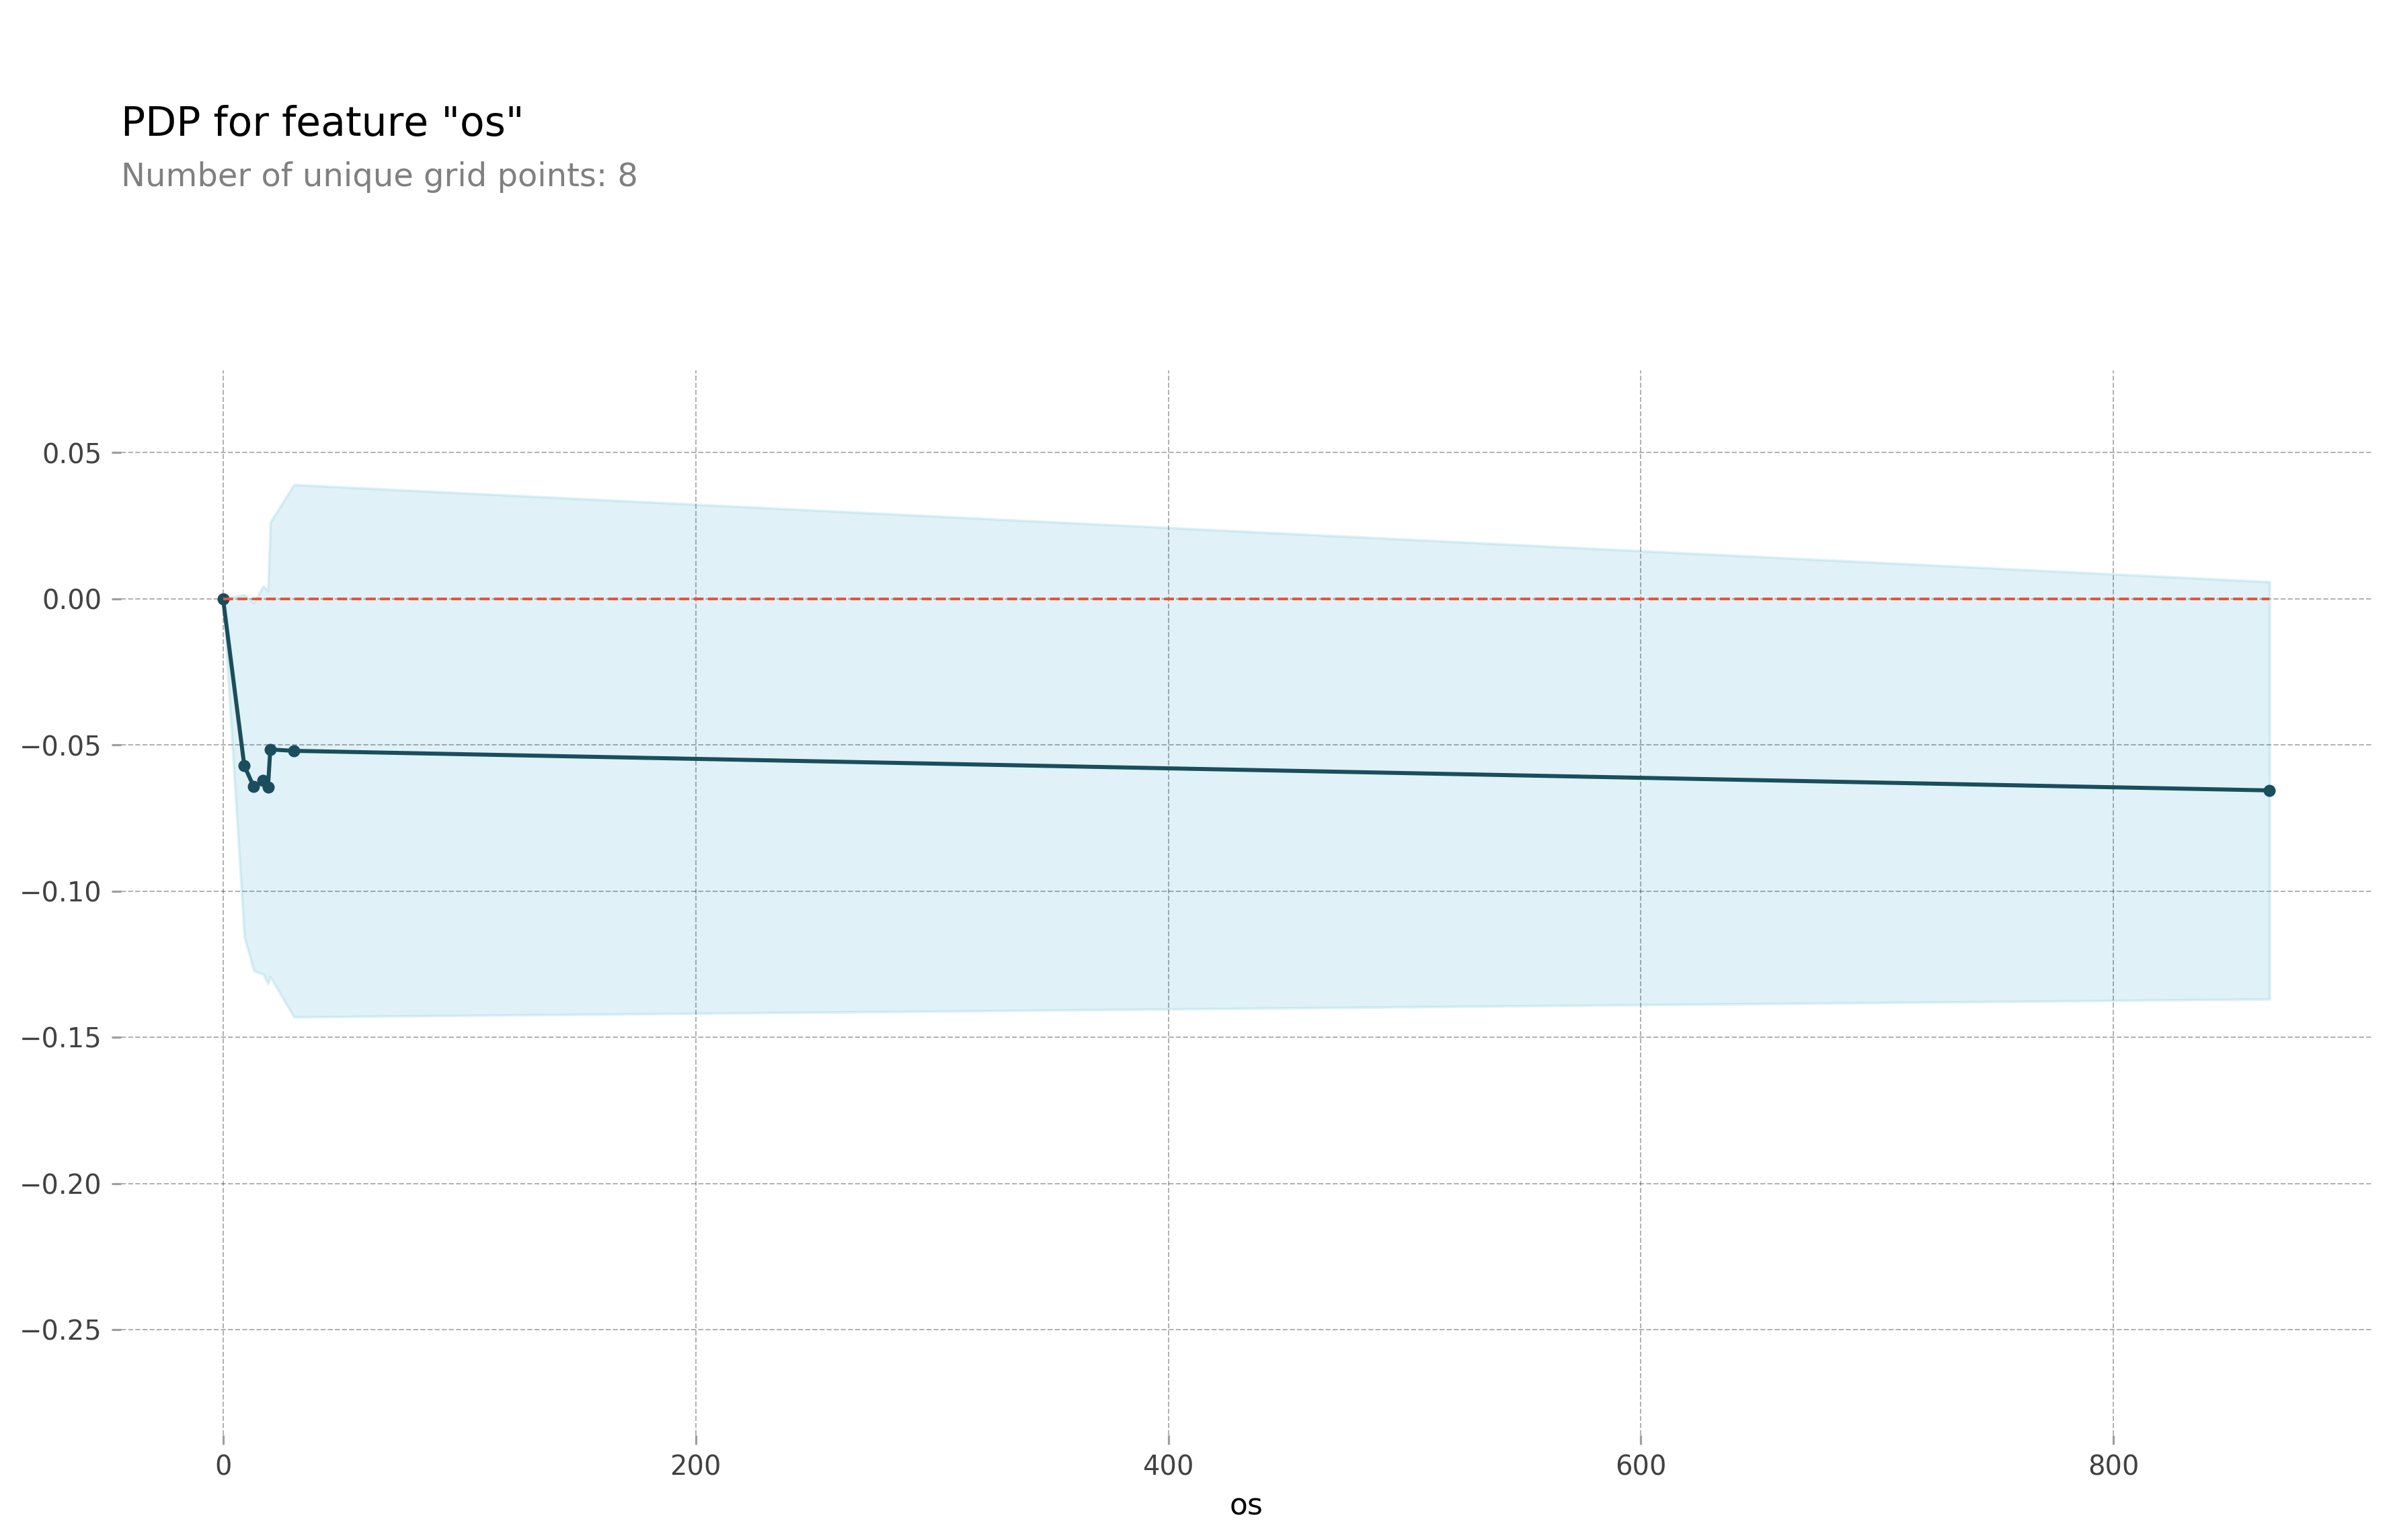

In [47]:
target_feature = "os"

isolated = pdp_isolate(
    model=rf1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb43f74e880>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb43faa10d0>})

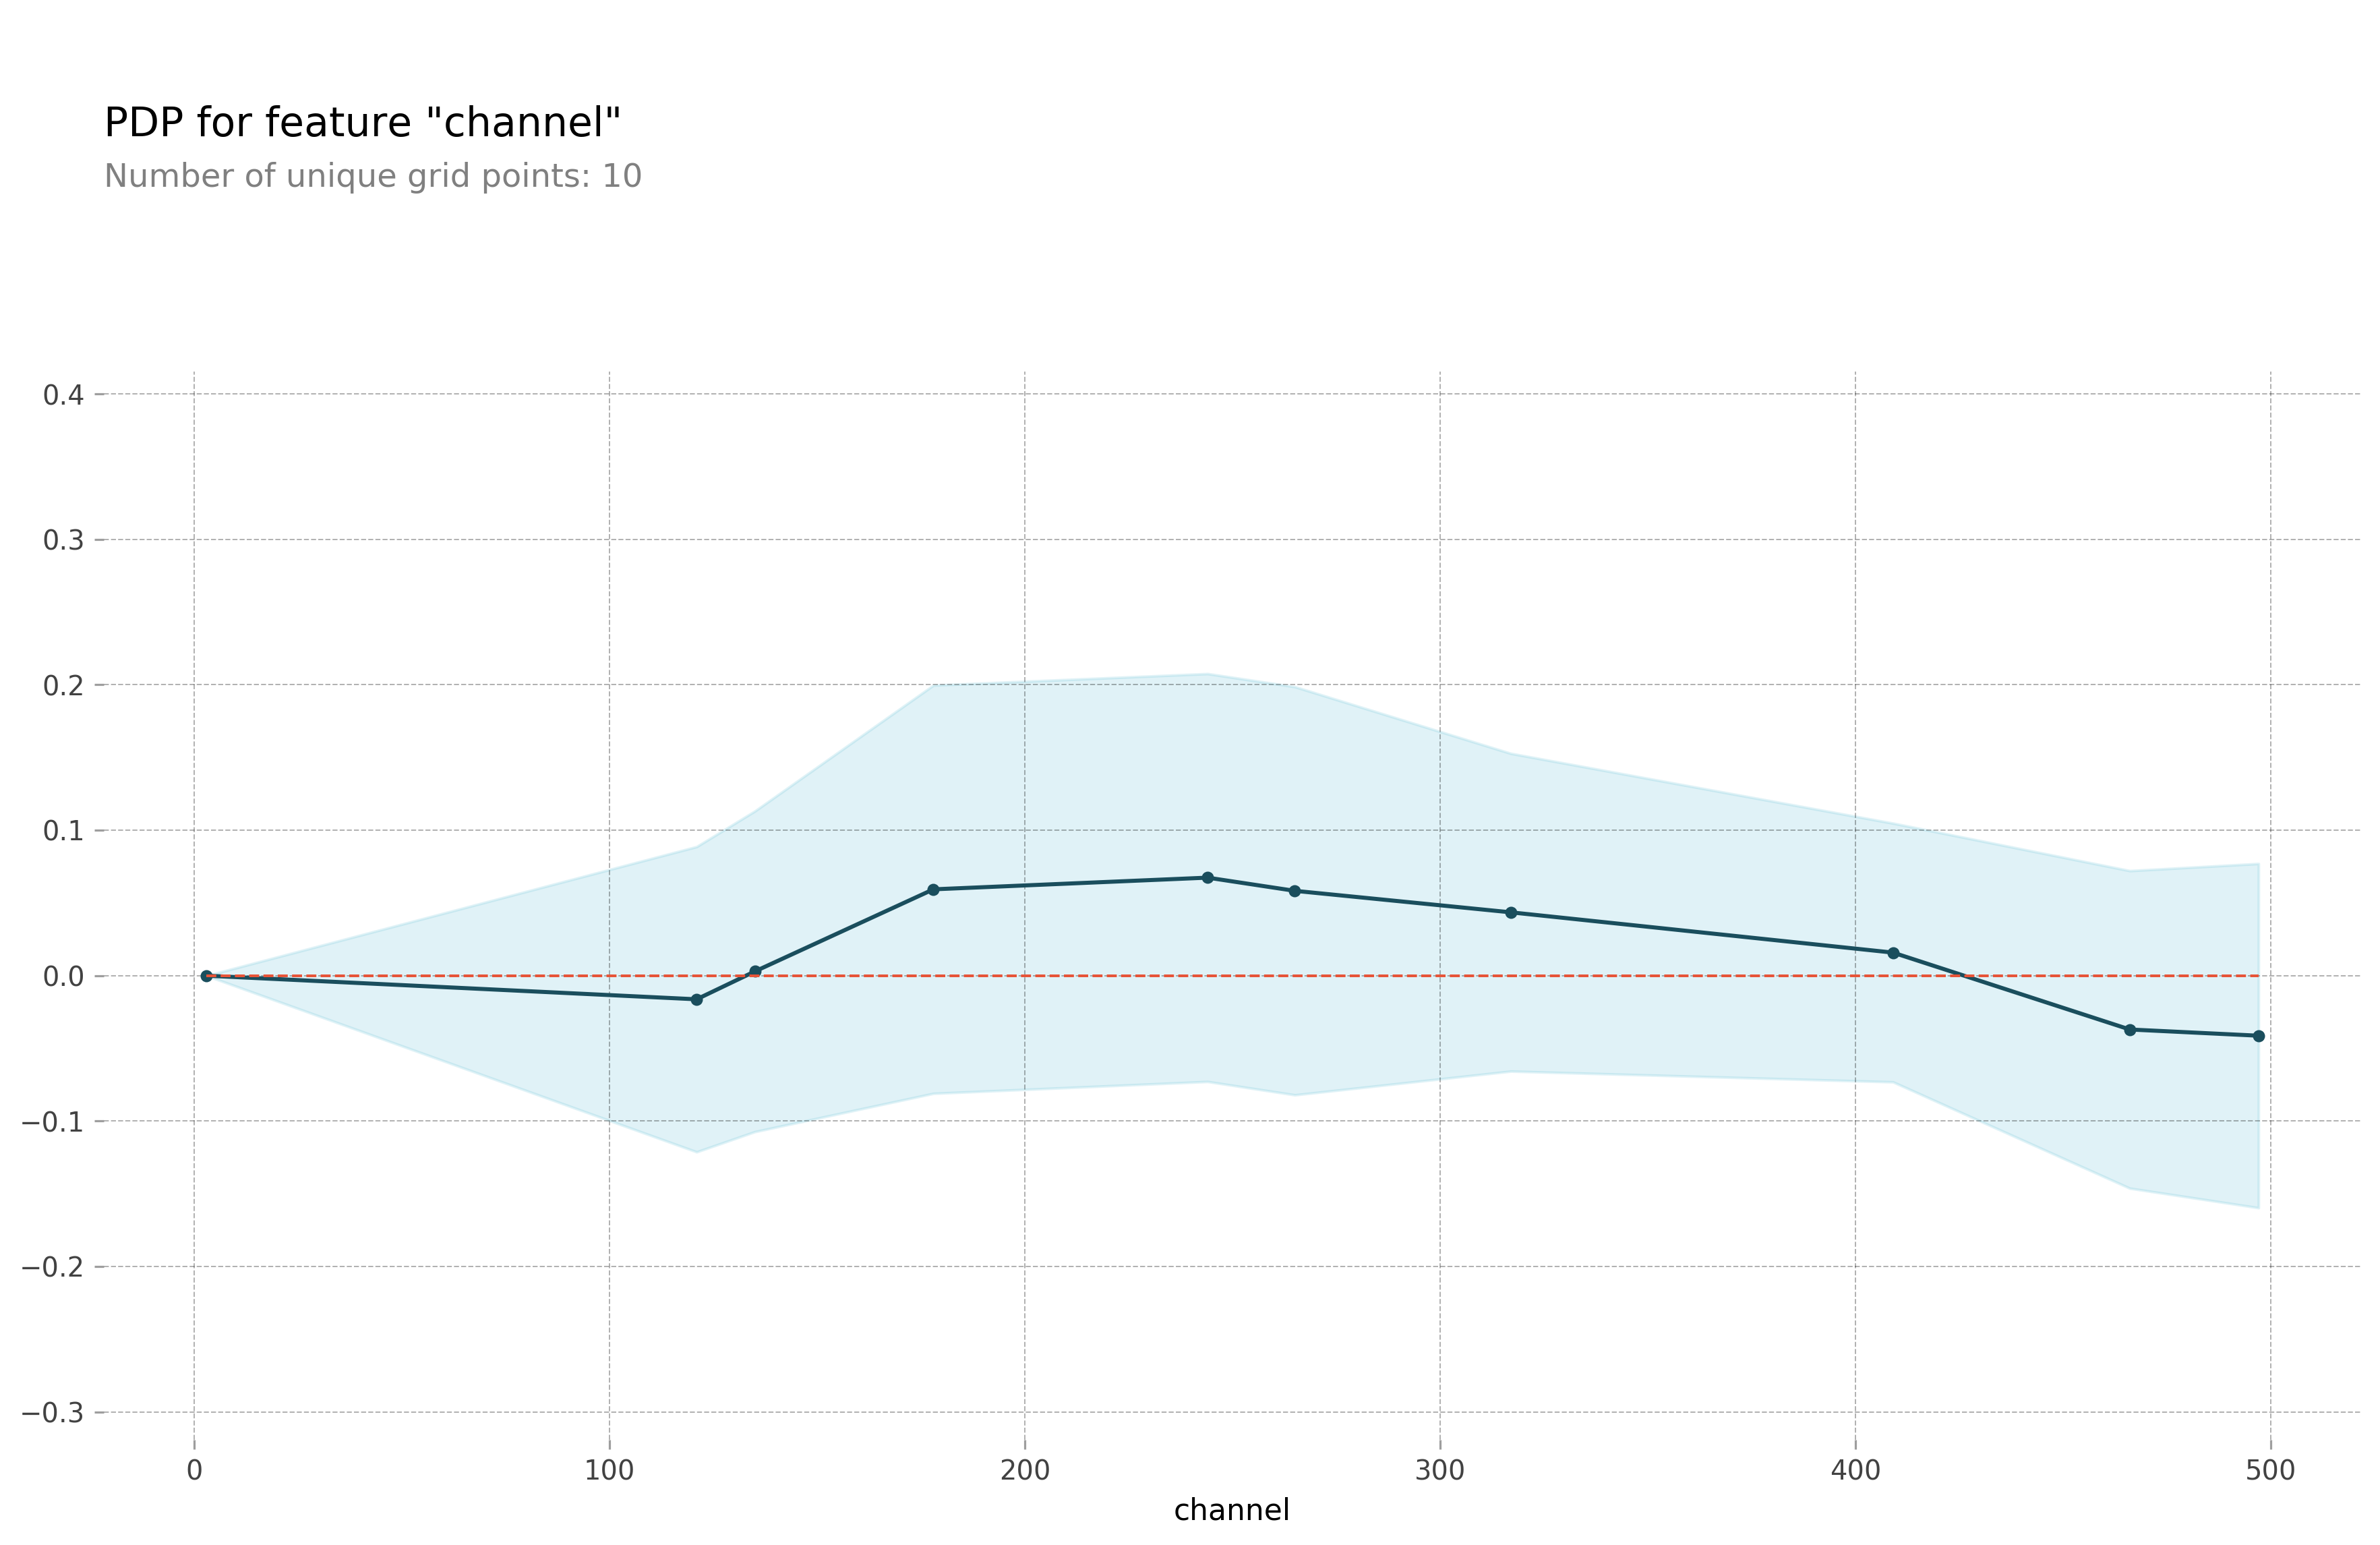

In [48]:
target_feature = "channel"

isolated = pdp_isolate(
    model=rf1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb45b4a60a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb441a16d30>})

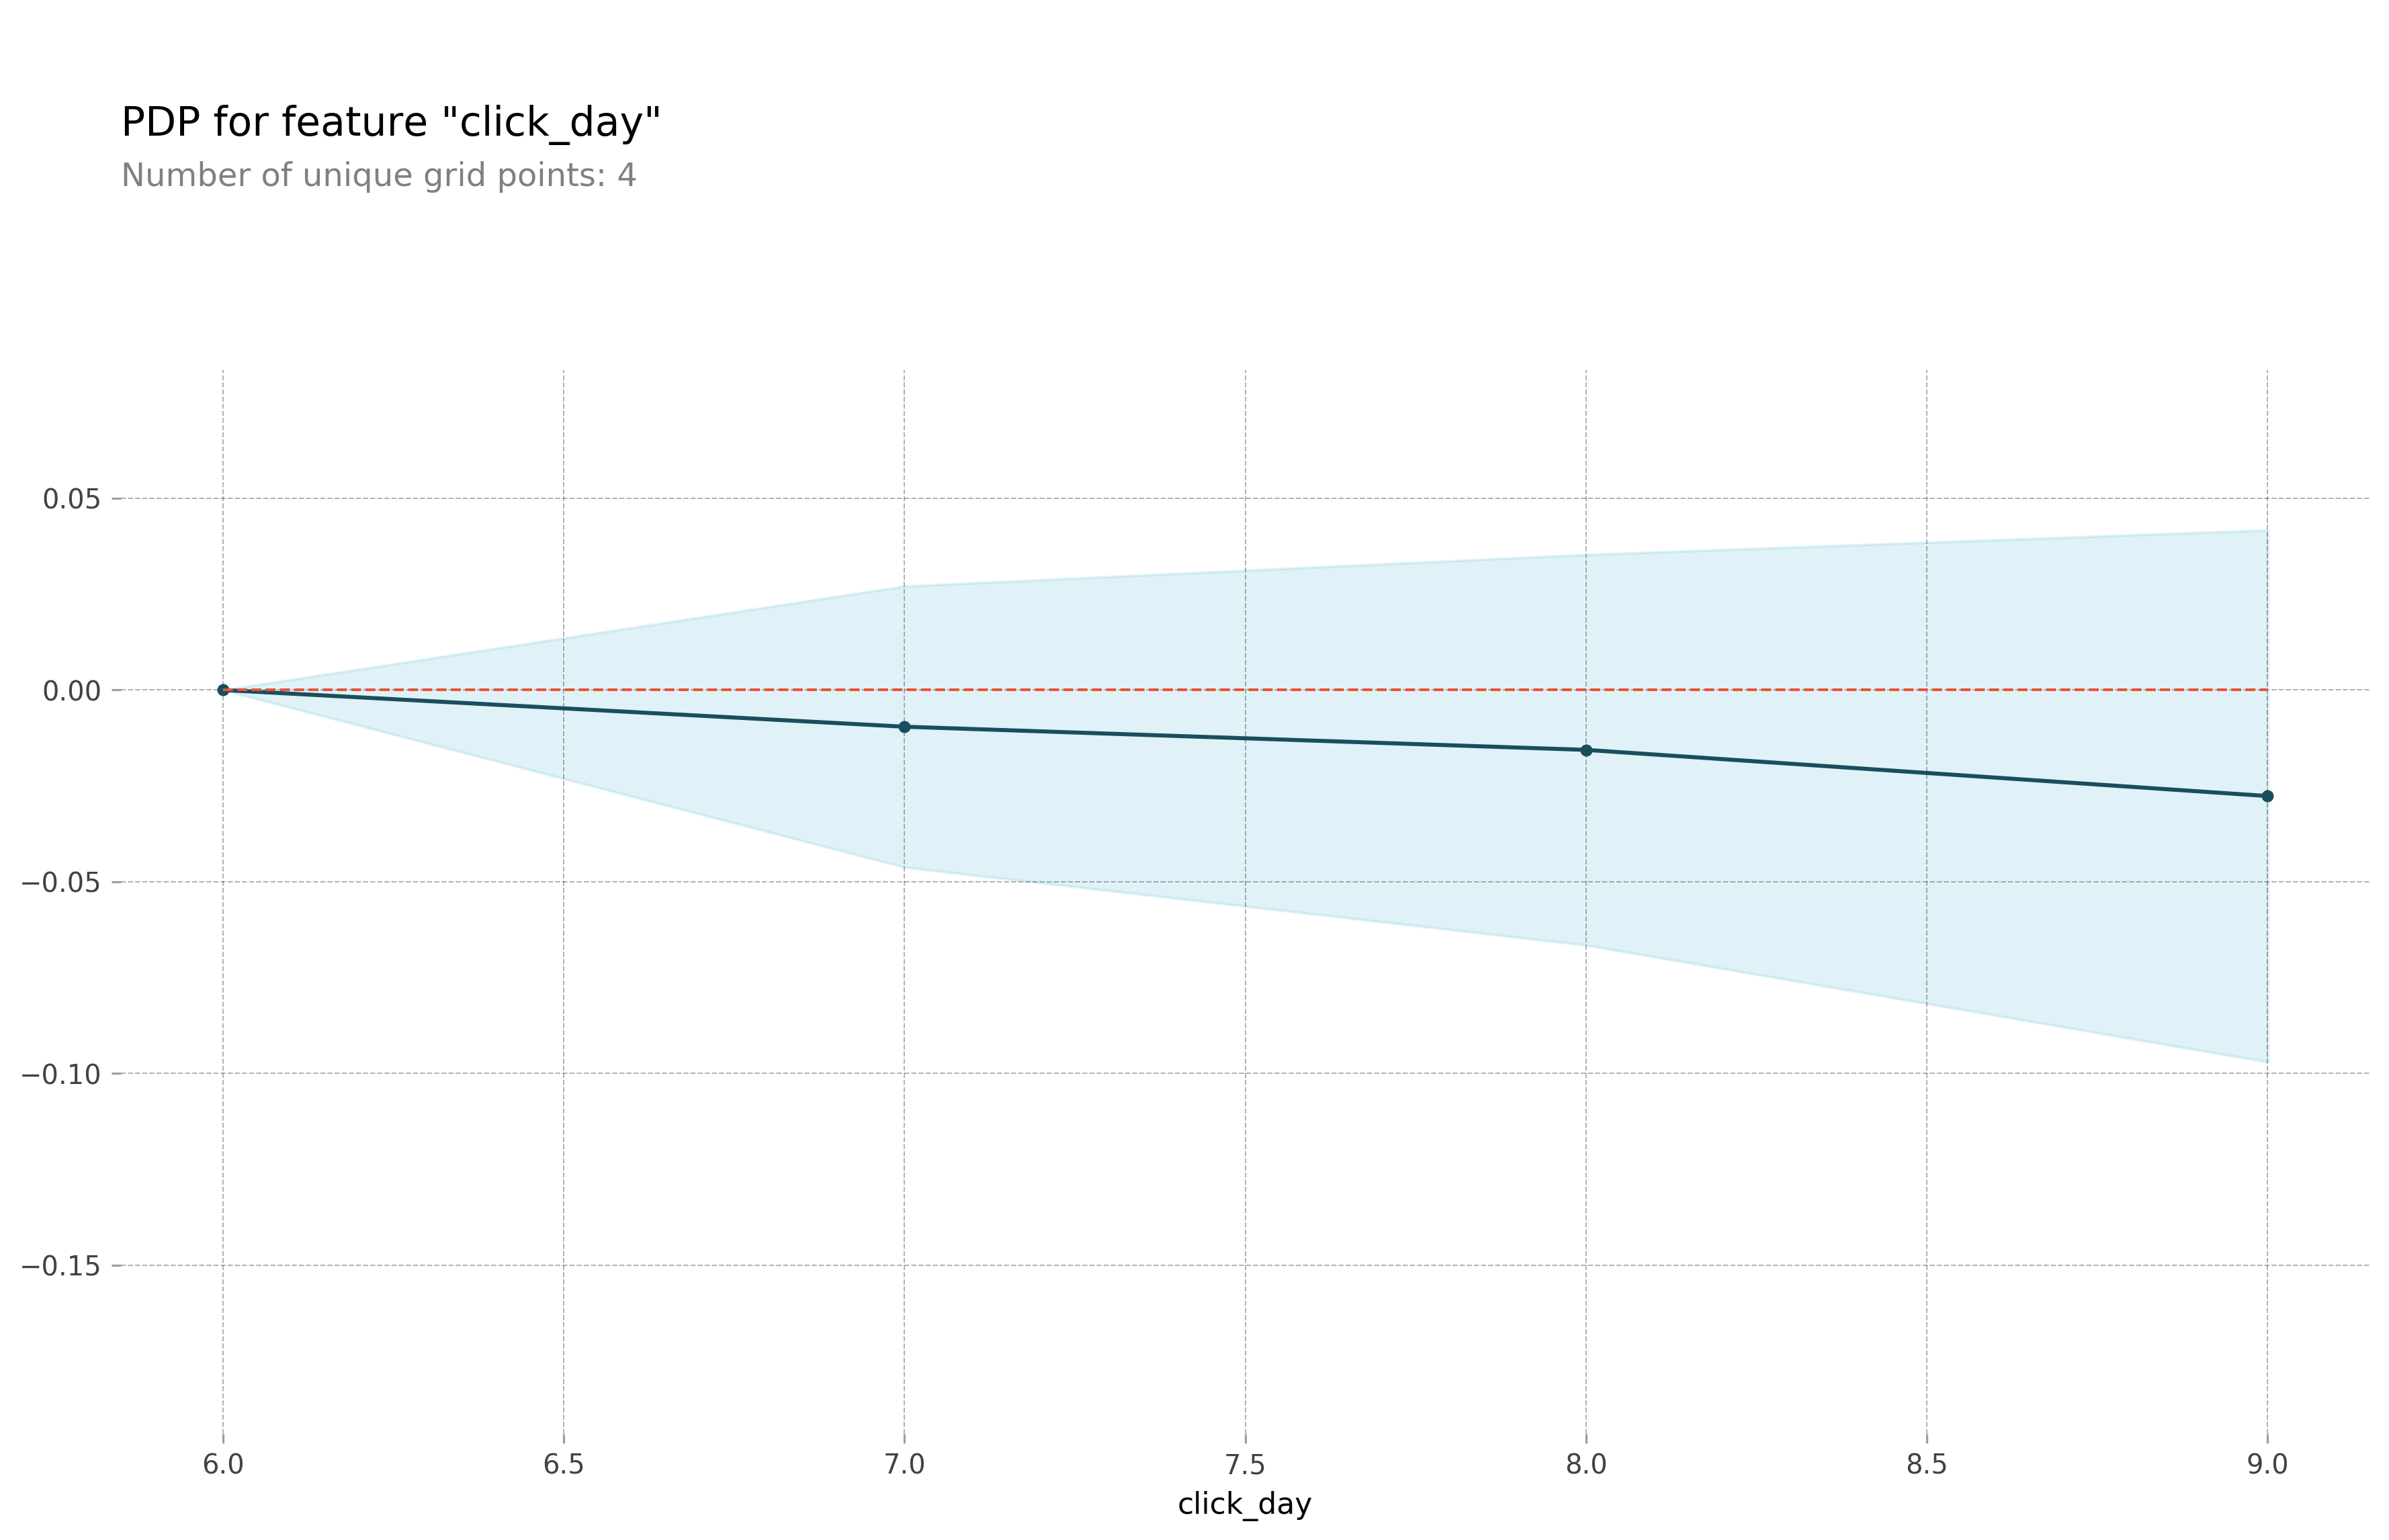

In [49]:
target_feature = "click_day"

isolated = pdp_isolate(
    model=rf1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb43fb17850>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb441a0a1c0>})

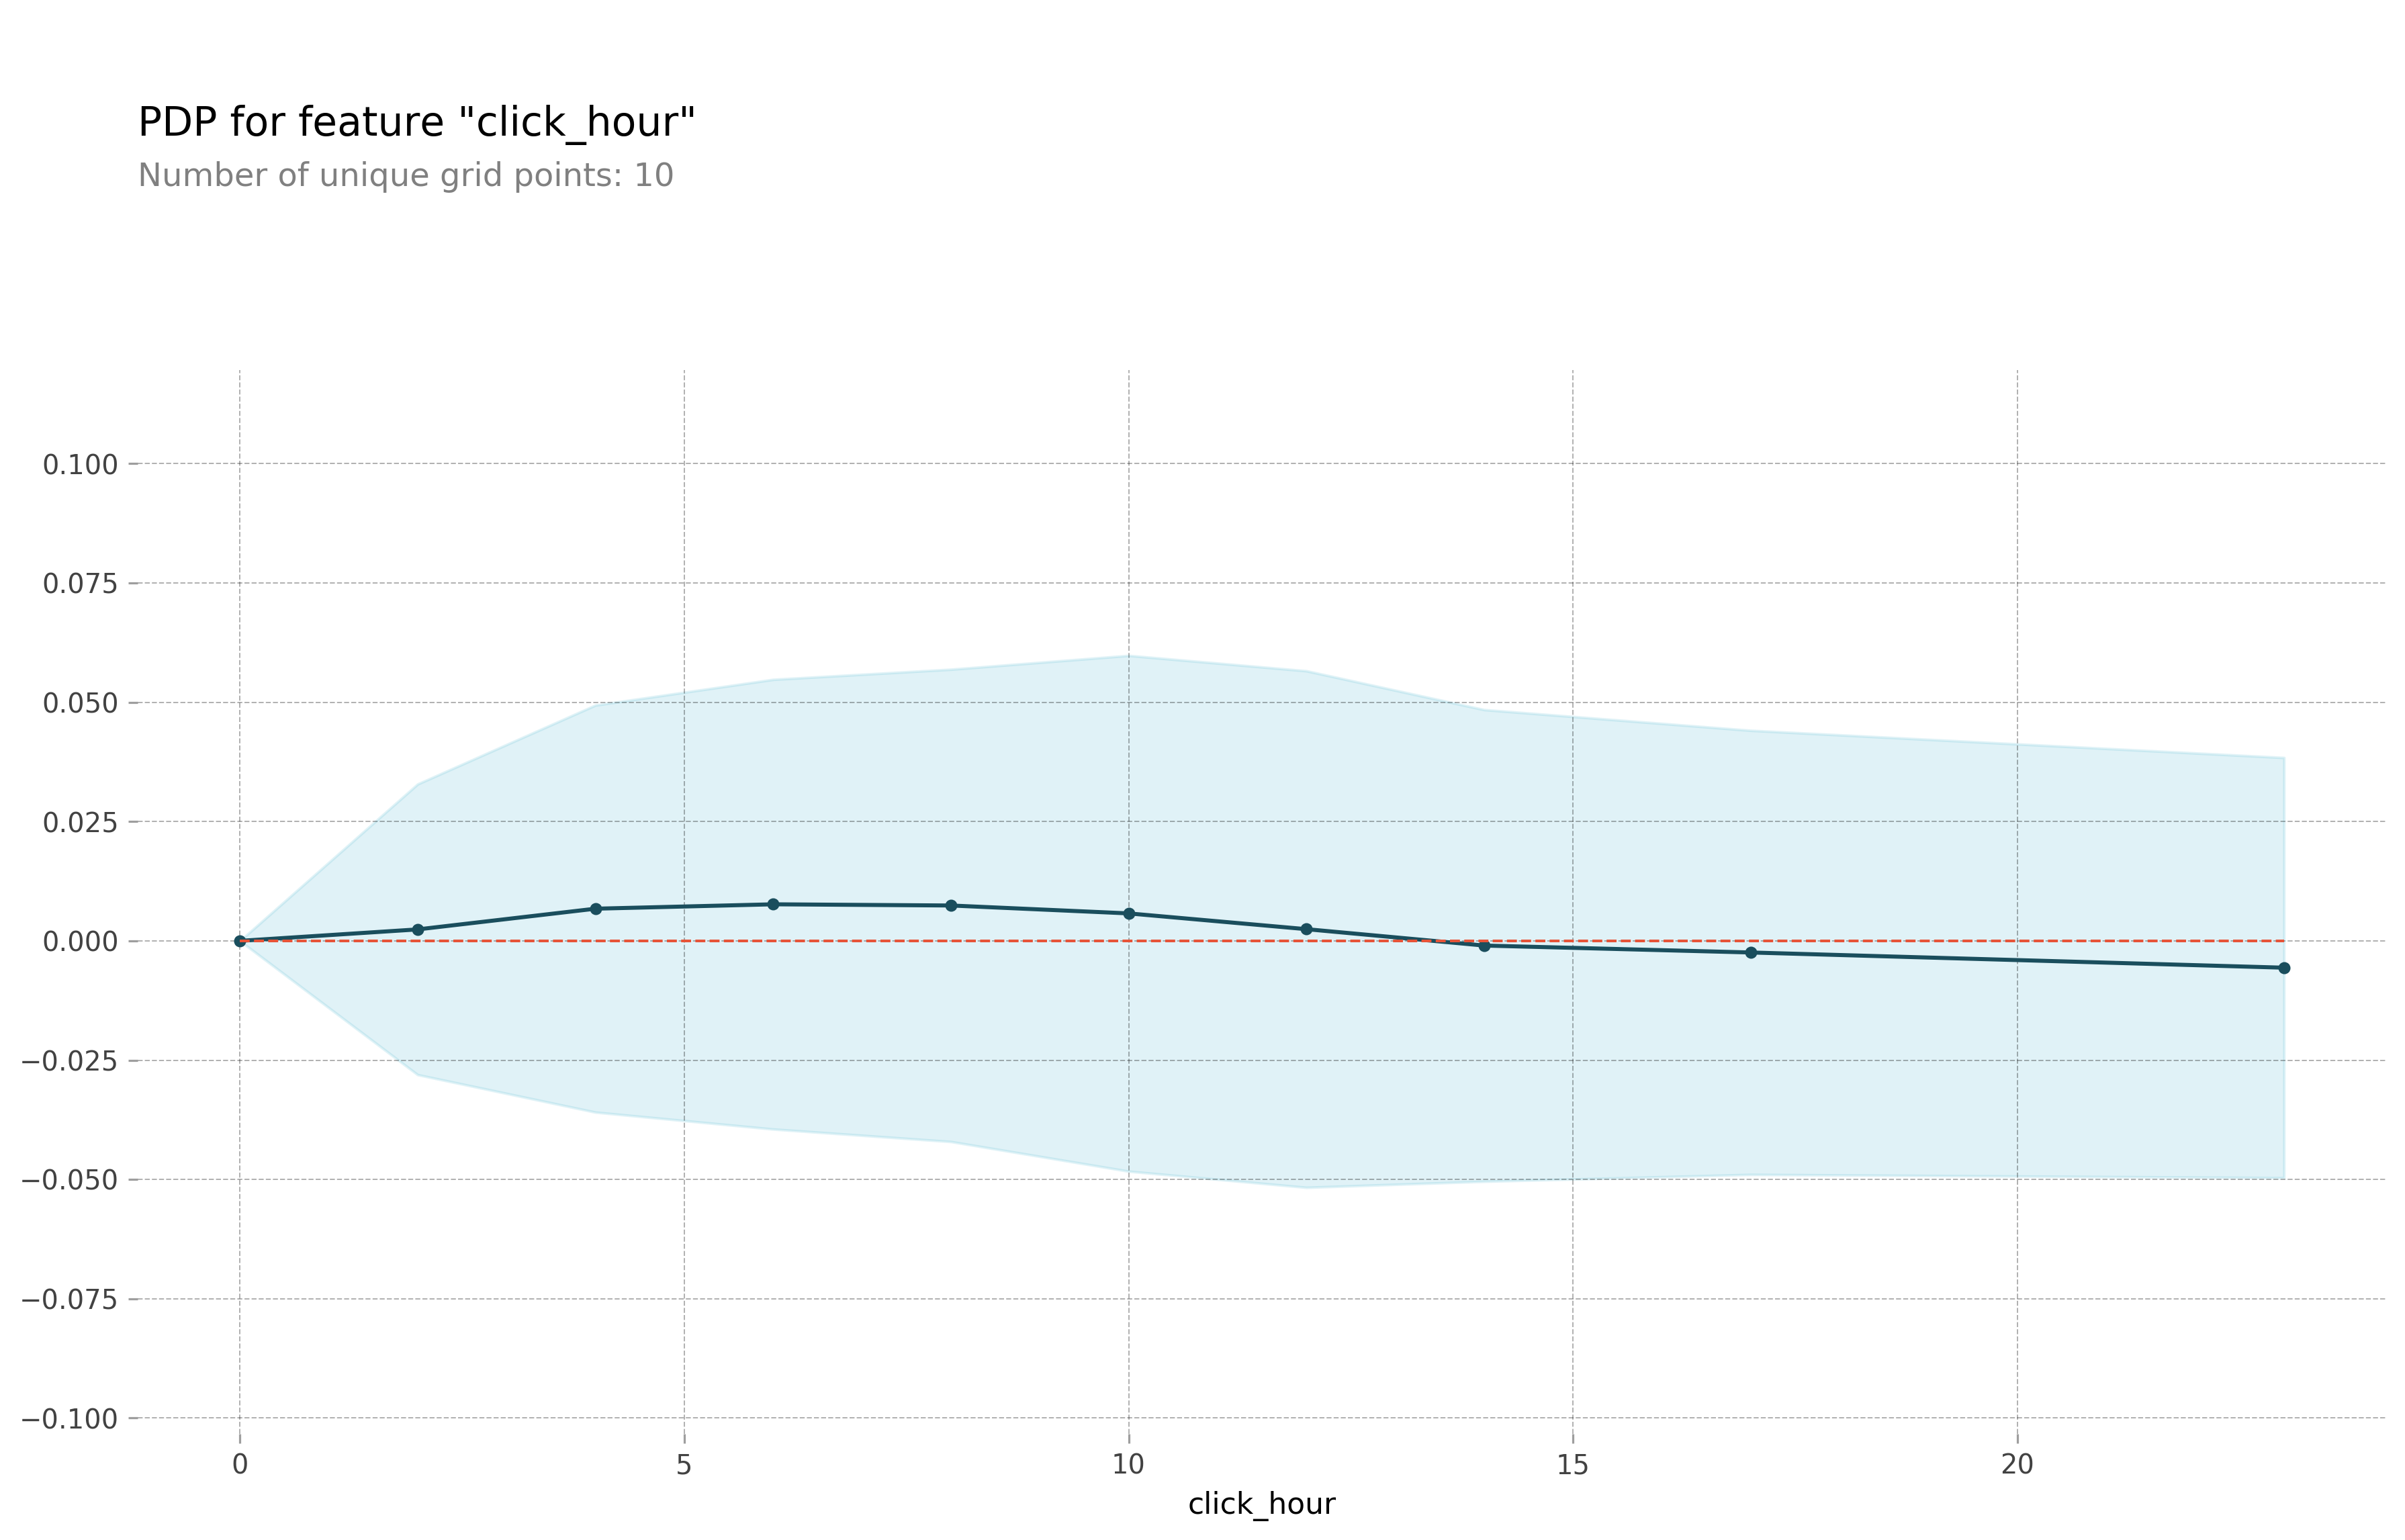

In [50]:
target_feature = "click_hour"

isolated = pdp_isolate(
    model=rf1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

In [51]:
# #shap

# import shap

# temp = X_test.copy()

# # shap.TreeExplainer 함수를 통해 모델에 explainer 생성
# explainer = shap.Explainer(rf1, temp)

# # SHAP 값 저장
# shap_values = explainer(temp)



In [52]:
# # 영향도 그래프 그리기
# shap.initjs()
# idx = 156
# shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])



# 예측값의 평균 0.7115 대비, 인덱스 156 의 예측값 0.36 인 요인 분석.
# shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], temp.iloc[idx,:])

In [53]:
#비즈니스 가치 환산
from sklearn.metrics import *
y_pred_val = rf1.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)
cm

array([[18631,    76],
       [   26,    17]])

In [54]:
# 비율로 환산. 1인당 기대가치 계산을 위해
cm_p = cm / np.sum(cm)
cm_p

array([[9.93653333e-01, 4.05333333e-03],
       [1.38666667e-03, 9.06666667e-04]])

In [57]:
# 4.05333333e-03 

# 다운로드 안했는데 맞다고 해서 가격 책정 => -됨
bv = np.array([[0,-4.05333333e-03],[-1.38666667e-03,9.06666667e-04]])
bv

array([[ 0.        , -0.00405333],
       [-0.00138667,  0.00090667]])

In [56]:
import eli5 

from eli5.sklearn import PermutationImportance 

# 순열 중요도 코드

pipe = make_pipeline(
    rf1
)

permuter = PermutationImportance(
    pipe.named_steps["randomforestclassifier"],  # model
    scoring="f1",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복하여 그 평균을 값으로 내라!!
    random_state=2)



# 스코어를 다시 계산합니다.

permuter.fit(X_test, y_test)



feature_names = X_test.columns.tolist()



eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성,
    feature_names=feature_names

)





# 순열중요도 상위 특성 추출  

feature_names = X_test.columns.tolist() 

permutation = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False) 

features = permutation[(permutation.values > 0)].index



#카디널리티 확인

X_test.nunique().sort_values().plot.barh()

plt.title("Cardinality")

AttributeError: ignored